# Imports

In [1]:
import time
import json
import matplotlib.pyplot as plt
import torch

import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import os
from torchvision.io import read_image
from PIL import Image

import numpy as np
import matplotlib.patches as patches
from torchvision import transforms

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torchmetrics.detection.map import MeanAveragePrecision

import pycocotools

In [2]:
# imports from local lib files
import utils
import transforms
import coco_eval
from engine import train_one_epoch, evaluate

# Baseline

## File paths

In [3]:
output_path = 'output'
img_folder = 'eccv_18_all_images_sm'

cis_test_ann_path = 'eccv_18_annotation_files/cis_test_annotations.json'
cis_val_ann_path = 'eccv_18_annotation_files/cis_val_annotations.json'
train_ann_path = 'eccv_18_annotation_files/train_annotations.json'
trans_test_ann_path = 'eccv_18_annotation_files/trans_test_annotations.json'
trans_val_ann_path = 'eccv_18_annotation_files/trans_val_annotations.json'

## Basic data exploration

In [4]:
cis_test_ann = json.load(open(cis_test_ann_path))
cis_val_ann = json.load(open(cis_val_ann_path))
train_ann = json.load(open(train_ann_path))
trans_test_ann = json.load(open(trans_test_ann_path))
trans_val_ann = json.load(open(trans_val_ann_path))

In [5]:
print('cis test set length:', len(cis_test_ann['images']))
print('cis val set length:', len(cis_val_ann['images']))
print('train set length:', len(train_ann['images']))
print('trans test set length:', len(trans_test_ann['images']))
print('trans val set length:', len(trans_val_ann['images']))

cis test set length: 15827
cis val set length: 3484
train set length: 13553
trans test set length: 23275
trans val set length: 1725


In [6]:
# i = 0

# boxes = [trans_val_ann['annotations'][j]['bbox'] for j in range(len(trans_val_ann['annotations'])) 
#          if trans_val_ann['annotations'][j]['image_id']==trans_val_ann['images'][i]['id'] 
#          and 'bbox' in trans_val_ann['annotations'][j].keys()]

# img_path = os.path.join('eccv_18_all_images_sm', trans_val_ann['images'][i]['file_name']) # to change

# image = read_image(img_path)

# fig, ax = plt.subplots()
# ax.imshow(image[0].squeeze(),cmap="gray")

# scale_x = image.shape[2] / trans_val_ann['images'][i]['width'] 
# scale_y = image.shape[1] / trans_val_ann['images'][i]['height']

# boxes = torch.as_tensor(boxes)

# for i in range(boxes.shape[0]):
#     boxes[i][0] = torch.round(boxes[i][0] * scale_x)
#     boxes[i][1] = torch.round(boxes[i][1] * scale_y)
#     boxes[i][2] = torch.round(boxes[i][2] * scale_x)
#     boxes[i][3] = torch.round(boxes[i][3] * scale_y)

#     boxes[i][2] = boxes[i][0] + boxes[i][2]
#     boxes[i][3] = boxes[i][1] + boxes[i][3]

# target = {}
# target["boxes"] = boxes

# rect = patches.Rectangle((boxes[0][0], boxes[0][1]), boxes[0][2]-boxes[0][0], 
#                          boxes[0][3]-boxes[0][1], linewidth=2, edgecolor='r', facecolor='none')
# ax.add_patch(rect)

## Utils

In [7]:
# In paper :  ' ... and employ horizontal flipping for data augmentation. ( for detection)

import transforms as T   # from git hub repo

data_transform = {'train': T.RandomHorizontalFlip(0.5)}

In [8]:
# Returns a list with the idx of images with at least one bounding box (img_wbbox) and a 
# list with the number of bbox for each valid image (num_bbox)
def get_img_with_bbox(file_path):
  
    file = json.load(open(file_path))
    img_wbbox = []
    num_bbox = []

    for i in range(len(file['images'])):
        bboxes = [file['annotations'][j]['bbox'] 
                  for j in range(len(file['annotations'])) 
                  if file['annotations'][j]['image_id']==file['images'][i]['id'] 
                  and 'bbox' in file['annotations'][j].keys()]

        if len(bboxes)!=0:
            img_wbbox.append(i)

            num_bbox.append(len(bboxes))

    return img_wbbox, num_bbox

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, label_path, img_dir, valid_img, transform = None, target_transform=None):
        self.label_file = json.load(open(label_path))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.valid_img = valid_img

    def __len__(self):
        return len(self.valid_img)

    def __getitem__(self, idx):
        
        idx = self.valid_img[idx] # consider only images with bbox annotations
        img_path = os.path.join(self.img_dir, self.label_file['images'][idx]['file_name'])
        image = read_image(img_path)

        conv = torchvision.transforms.ToTensor()
        # if image.shape[0]==1:
        # some images have only one channel, we convert them to rgb
        image = Image.open(img_path).convert("RGB")
        image = conv(image)

        boxes = [self.label_file['annotations'][j]['bbox'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]
        
        label = [self.label_file['annotations'][j]['category_id'] 
                 for j in range(len(self.label_file['annotations'])) 
                 if self.label_file['annotations'][j]['image_id']==self.label_file['images'][idx]['id']]

        # transform bbox coords to adjust for resizing
        scale_x = image.shape[2] / self.label_file['images'][idx]['width'] 
        scale_y = image.shape[1] / self.label_file['images'][idx]['height']

        boxes = torch.as_tensor(boxes)
        for i in range(boxes.shape[0]):
            boxes[i][0] = torch.round(boxes[i][0] * scale_x)
            boxes[i][1] = torch.round(boxes[i][1] * scale_y)
            boxes[i][2] = torch.round(boxes[i][2] * scale_x)
            boxes[i][3] = torch.round(boxes[i][3] * scale_y)

            boxes[i][2] = boxes[i][0] + boxes[i][2] # to transform to pytorch bbox format
            boxes[i][3] = boxes[i][1] + boxes[i][3]

            #boxes[i][0]*=scale_x
            #boxes[i][1]*=scale_y
            #boxes[i][2]*=scale_x
            #boxes[i][3]*=scale_y

        label = torch.as_tensor(label)
        label = torch.where(label==30,0,1)  # 0 if empty (categ id = 30), 1 if animal
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = label
        target["image_id"] = image_id
        target['area']=area
        target['iscrowd']=iscrowd

        # TO DO : resize all to same size

        if self.transform:
            # transform image AND target
            image, target = self.transform(image, target)
        if self.target_transform:
            label = self.target_transform(label)

        return image, target

## Pre-trained models

In [ ]:
# Inspired from https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=YjNHjVMOyYlH

### Model with only the last layer to train

In [ ]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

### Model with deeper layers to train

In [10]:
def get_model_from_pretrained(num_classes):

    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    for param in model.parameters(): # to freeze all existing weights
        param.requires_grad = False

    for param in model.roi_heads.parameters():
        param.requires_grad = True

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

# like in the paper, construct the scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

### Create the dataloaders
To load the data of the dataset efficiently for the model

In [11]:
train_valid_img,_ = get_img_with_bbox(train_ann_path)
train_data = CustomImageDataset(train_ann_path, img_folder, train_valid_img)
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

In [12]:
trans_val_valid_img,_ = get_img_with_bbox(trans_val_ann_path)
trans_valid_data = CustomImageDataset(trans_val_ann_path, img_folder, trans_val_valid_img)
trans_valid_dataloader = DataLoader(trans_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [13]:
cis_val_valid_img,_ = get_img_with_bbox(cis_val_ann_path)
cis_valid_data = CustomImageDataset(cis_val_ann_path, img_folder, cis_val_valid_img)
cis_valid_dataloader = DataLoader(cis_valid_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [14]:
cis_test_img,_ = get_img_with_bbox(cis_test_ann_path)
cis_test_data = CustomImageDataset(cis_test_ann_path,img_folder, cis_test_img)
cis_test_dataloader = DataLoader(cis_test_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

In [15]:
trans_test_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_data = CustomImageDataset(trans_test_ann_path,img_folder, trans_test_img)
trans_test_dataloader = DataLoader(trans_test_data, batch_size=10, shuffle=True, collate_fn=utils.collate_fn)

## Loading/Importing a model
#### Need to initiate the model, the optimizer and de scheduler before loading

In [17]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/25_roi_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/25_roi_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/25_roi_scheduler.pt'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Logs utils

#### Train logs utils

In [18]:
import time

In [19]:
# Converts the smoothed values to a dictionnary of each values
def smoothed_value_to_str(smoothed_value):
    d_values = {}
    d_values['median'] = smoothed_value.median
    d_values['avg'] = smoothed_value.avg
    d_values['global_avg'] = smoothed_value.global_avg
    d_values['max'] = smoothed_value.max
    d_values['value'] = smoothed_value.value
    return d_values

In [20]:
# Converts the train logs from MetricLogger to list
def train_logs_to_lst(logs):
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].meters.keys():
            d[key] = smoothed_value_to_str(logs[i].meters[key])
        lst.append(d)
    return lst

In [21]:
# Puts the training logs into a json file with time dependent file name
def train_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    train_metric_logs = train_logs_to_lst(logs)
    filename = ftime + "_train_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(train_metric_logs, f, ensure_ascii=False, indent=4)

#### Valid logs utils

In [22]:
# Merge the dicts of a list 
def merge_dict(logs):
    logs_better = []
    try:
        for i in range(len(logs)):
            logs_better.append({**logs[i][0], **logs[i][1], **logs[i][2], **logs[i][3]})
        return logs_better
    except:
        print(logs[0])
        logs_better = logs
        return logs_better

In [23]:
# Converts the valid logs from list of dictionnaries to string
def valid_logs_to_lst(valid_logs):
    logs = merge_dict(valid_logs)
    lst = []
    for i in range(len(logs)):
        d = {}
        for key in logs[i].keys():
            d[key] = logs[i][key].cpu().numpy().tolist()
        lst.append(d)
    return lst

In [24]:
# Puts the cis validation logs into a json file with time dependent file name
def cis_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_cis_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

In [25]:
# Puts the trans validation logs into a json file with time dependent file name
def trans_valid_logs_to_json(logs, ftime=time.strftime("%Y%m%d_%H%M%S")):
    valid_metric_logs = valid_logs_to_lst(logs)
    filename = ftime + "_trans_valid_logs.json"
    
    with open('saved_logs/' + filename, 'w', encoding='utf-8') as f:
        json.dump(valid_metric_logs, f, ensure_ascii=False, indent=4)

## Training the model

In [173]:
# PARAMETERS TO TUNE BEFORE TRAINING
num_epochs = 25

In [27]:
# CHECK DEVICE BEFORE TRAINING
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1080 Ti'

In [ ]:
# Defining the train function
def train(dataloader, num_epochs, save_logs=True, save_model=True, print_freq=100):
    
    all_train_logs = []
    all_cis_valid_logs = []
    all_trans_valid_logs = []

    for epoch in range(num_epochs):
        
        # train for one epoch, printing every 100 images
        train_logs = train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq)
        all_train_logs.append(train_logs)
        
        # update the learning rate
        lr_scheduler.step()
        
        # evaluate on the validation dataset after training one epoch
        for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                trans_loss_dict = model(images, targets)
                trans_loss_dict = [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
                all_trans_valid_logs.append(trans_loss_dict)


        for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                cis_loss_dict = model(images, targets)
                cis_loss_dict = [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
                all_cis_valid_logs.append(cis_loss_dict)
    
    filetime = time.strftime("%Y%m%d_%H%M%S")
    
    if save_logs:
        
        # save the train, cis valid and trans valid logs
        train_logs_to_json(all_train_logs, filetime)
        cis_valid_logs_to_json(all_cis_valid_logs, filetime)
        trans_valid_logs_to_json(all_trans_valid_logs, filetime)
        
    if save_model:
        
        # save the model, the optimizer and the scheduler
        torch.save(model.state_dict(), 'saved_models/' + filetime + 'model.pt')
        torch.save(optimizer.state_dict(), 'saved_models/' + filetime + 'optimizer.pt')
        torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + 'scheduler.pt')
    
    return all_train_logs, all_trans_valid_logs, all_cis_valid_logs


#### This next cell starts the training of the model

In [ ]:
# TRAIN
all_train_logs, all_trans_valid_logs, all_cis_valid_logs = train(dataloader=train_dataloader, num_epochs=num_epochs)

### Saving the last training logs to variables
##### Ensures that if you hit the training cell, you don't lose the variables containing the logs from the last run

In [57]:
last_train_logs = all_train_logs
last_trans_valid_logs = all_trans_valid_logs
last_cis_valid_logs = all_cis_valid_logs

## Saving manually every logs from training to json files

In [58]:
# Saves the log with the same time
train_logs_to_json(last_train_logs)
trans_valid_logs_to_json(last_trans_valid_logs)
cis_valid_logs_to_json(last_cis_valid_logs)

## Saving the model

In [59]:
# save the model, the optimizer and the scheduler
filetime = time.strftime("%Y%m%d_%H%M%S")

torch.save(model.state_dict(), 'saved_models/' + filetime + '_model.pt')
torch.save(optimizer.state_dict(), 'saved_models/' + filetime + '_optimizer.pt')
torch.save(lr_scheduler.state_dict(), 'saved_models/' + filetime + '_scheduler.pt')

## Exploration of the raw logs
##### Only look at the MetricLogger if you just trained the model. You cannot import the model and then check the MetricLogger.

In [60]:
all_train_logs[0].meters

defaultdict(utils.SmoothedValue,
            {'lr': <utils.SmoothedValue at 0x1ceb9ed6688>,
             'loss': <utils.SmoothedValue at 0x1ceb9e63908>,
             'loss_classifier': <utils.SmoothedValue at 0x1cec957bbc8>,
             'loss_box_reg': <utils.SmoothedValue at 0x1ce9b04bbc8>,
             'loss_objectness': <utils.SmoothedValue at 0x1ce98880688>,
             'loss_rpn_box_reg': <utils.SmoothedValue at 0x1ceb9ee68c8>})

In [61]:
all_train_logs[0].meters['loss_box_reg'].global_avg

0.06483003193878836

#### Here we check the amount of logs per epoch for each categories and the type

In [63]:
print(all_cis_valid_logs[0])
print("total length:", len(all_cis_valid_logs))
print("-"*8)
print("per epoch length:", len(all_cis_valid_logs)/num_epochs)

[{'loss_classifier': tensor(0.0232)}, {'loss_box_reg': tensor(0.0417)}, {'loss_objectness': tensor(0.0566)}, {'loss_rpn_box_reg': tensor(0.0073)}]
total length: 2505
--------
per epoch length: 167.0


In [ ]:
print(all_trans_valid_logs[0])
print("total length:", len(all_trans_valid_logs))
print("-"*8)
print("per epoch length:", len(all_trans_valid_logs)/num_epochs)

## Looking at/Loading the logs in convenient ways
Here we define the variables "train_logs", "cis_valid_logs" and "trans_valid_logs" that will be used in the methods for the results and the visualisations.

We can import logs or use the ones from training.

### OPTIONAL - Can load some logs right here

In [162]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '25_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = train_logs + json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = cis_valid_logs + json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = trans_valid_logs + json.load(f)

### OPTIONAL - Combine 2 loaded logs

In [161]:
# Imported logs - format: name = "NAME_OR_TIME"      Exemple file format: "NAME_OR_TIME_train_logs"

file_time_or_nickname = '10_roi' # VALUE TO CHANGE TO THE IMPORTED FILES

# Import training logs
with open('saved_logs/' + file_time_or_nickname + '_train_logs.json', "r") as f:
    train_logs = json.load(f)

# Import cis valid logs
with open('saved_logs/' + file_time_or_nickname + '_cis_valid_logs.json', "r") as f:
    cis_valid_logs = json.load(f)

# Import trans valid logs
with open('saved_logs/' + file_time_or_nickname + '_trans_valid_logs.json', "r") as f:
    trans_valid_logs = json.load(f)

### Combination of old logs

#### Train

In [145]:
train_logs_0_9 = [train_logs[i]['loss_box_reg'] for i in range(0, 10)]

In [141]:
train_logs_10_25 = [train_logs[i]['loss_box_reg']['global_avg'] for i in range(10, 25)]

In [146]:
train_logs = train_logs_0_9 + train_logs_10_25

In [148]:
results_train_loss = train_logs

#### Cis valid

### Put the last trained logs into convenient list variables
##### Converts the logs to lists and the tensors to numpy - ONLY IF MODEL HAVE BEEN TRAINED IN THIS KERNEL

In [119]:
train_logs = train_logs_to_lst(last_train_logs)
cis_valid_logs = valid_logs_to_lst(last_cis_valid_logs)
trans_valid_logs = valid_logs_to_lst(last_trans_valid_logs)

## Results

In [129]:
# To confirm that the data is loaded properly
len(train_logs)

25

In [ ]:
num_epochs=len(train_logs)

In [121]:
# Train loss to print (here we use global_avg but we can use: value, median, avg, max or global_avg)
results_train_loss = []

for i in range(num_epochs):
    results_train_loss.append(train_logs[i]['loss_box_reg']['global_avg'])

In [174]:
# Cis valid loss to print
results_cis_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(167):
        loss_interm += cis_valid_logs[(167 * i) + j]['loss_box_reg']
    results_cis_valid_loss.append(loss_interm)

In [175]:
# Trans valid loss to print
results_trans_valid_loss = [] # cis

for i in range(num_epochs):
    loss_interm = 0
    for j in range(154):
        loss_interm += trans_valid_logs[(154 * i) + j]['loss_box_reg']
    results_trans_valid_loss.append(loss_interm)

### Plots

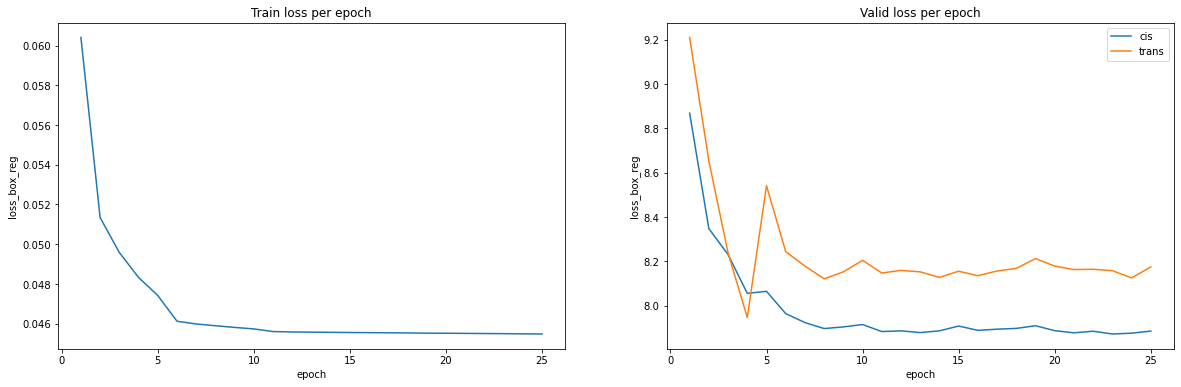

In [176]:
# Printing the different plots
fig, ax = plt.subplots(1,2, figsize=(20,6))

ax[0].plot(np.arange(1, num_epochs + 1), results_train_loss, label='train')
ax[0].set_title('Train loss per epoch')
ax[0].set_ylabel('loss_box_reg')
ax[0].set_xlabel('epoch')

plt.title('Train loss per epoch')
ax[1].plot(np.arange(1, num_epochs + 1), results_cis_valid_loss, label='cis')
ax[1].plot(np.arange(1, num_epochs + 1), results_trans_valid_loss, label='trans')
ax[1].set_title('Valid loss per epoch')
ax[1].set_ylabel('loss_box_reg')
ax[1].set_xlabel('epoch')
ax[1].legend()


#### Save the figure to pdf format in the figures folder

In [177]:
fig.savefig("figures/25_epochs_roi_.pdf")

## Make Predictions with a model

### OPTIONAL - Can load a model right here to test the predictions quickly
#### Need to initiate the model, the optimizer and de scheduler before loading

In [ ]:
# NEED TO INITIATE THE MODEL, THE OPTIMIZER AND THE SCHEDULER BEFOREHAND (if )
# load the model, the optimizer and the scheduler
model.load_state_dict(torch.load('saved_models/25_roi_model.pt'))
optimizer.load_state_dict(torch.load('saved_models/25_roi_optimizer.pt'))
lr_scheduler.load_state_dict(torch.load('saved_models/25_roi_scheduler.pt'))
model.eval()

### Predictions

In [71]:
train_features, train_labels = next(iter(trans_valid_dataloader))
image = list(image.to(device) for image in train_features)

model.eval()
with torch.no_grad():
      pred = model(image)

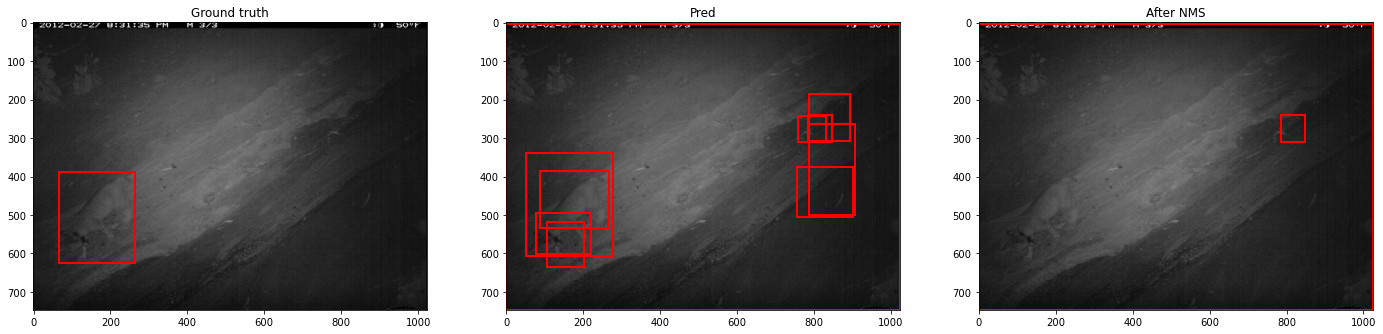

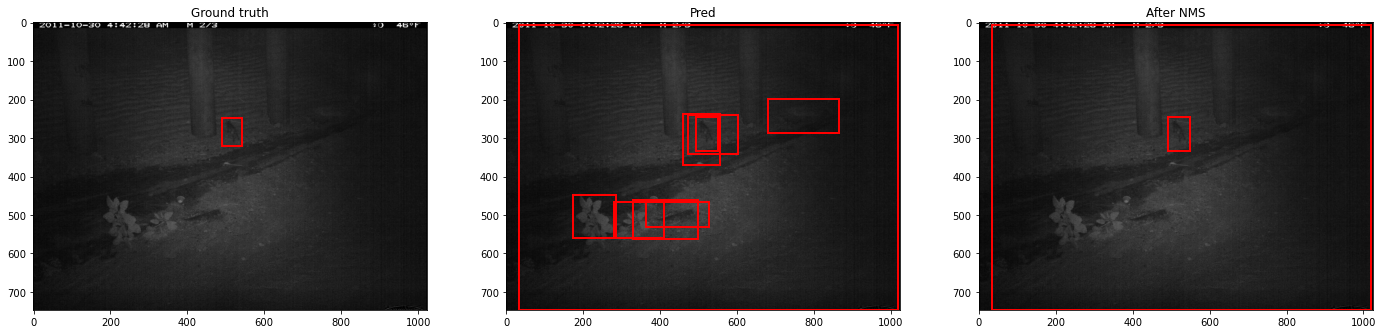

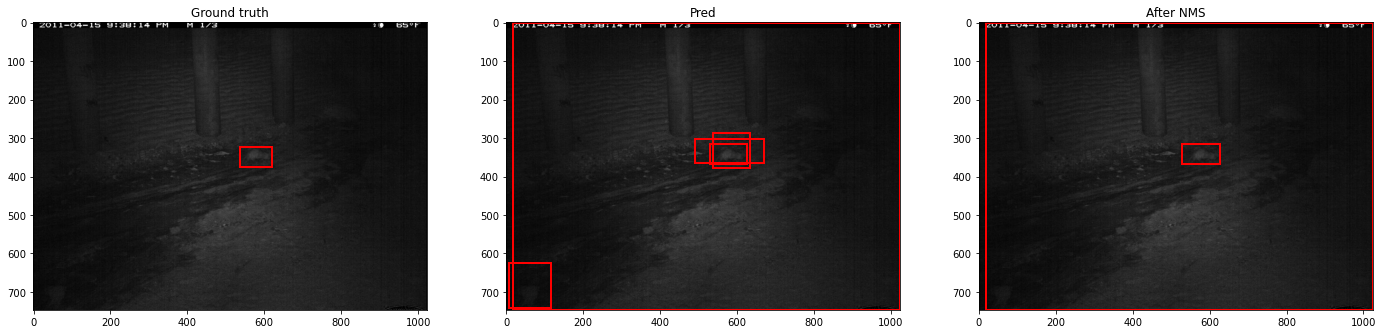

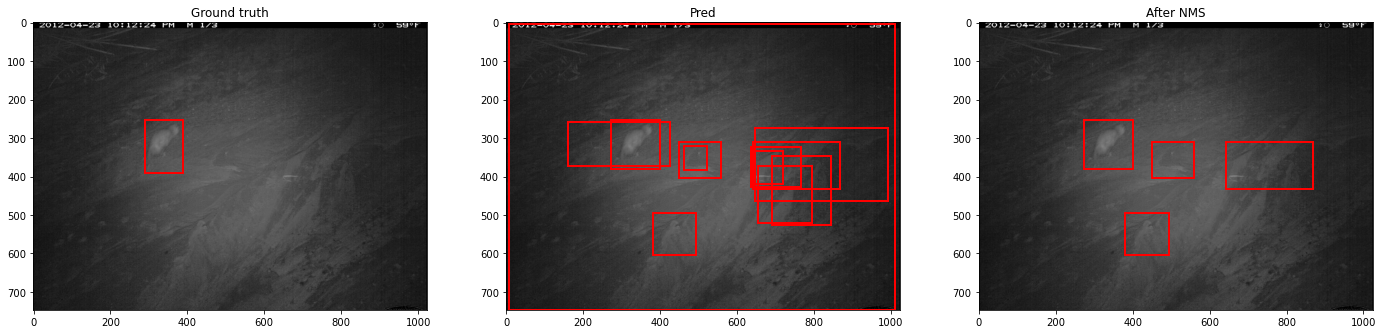

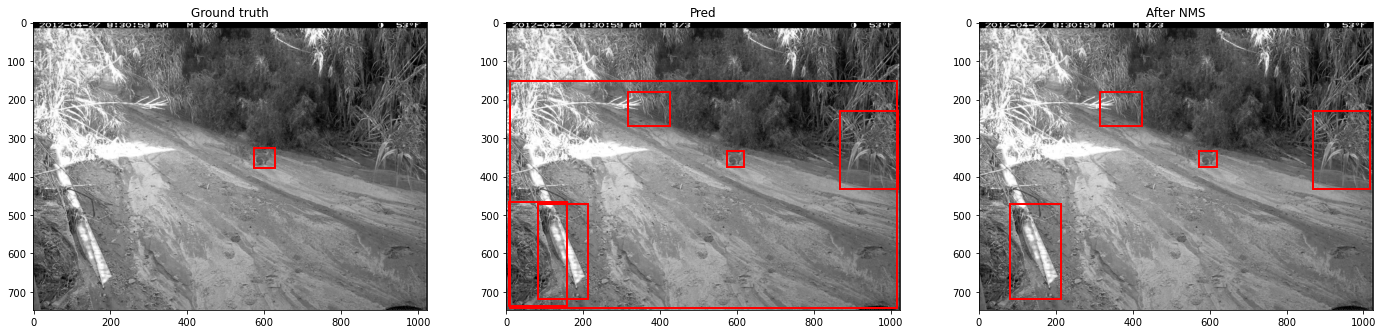

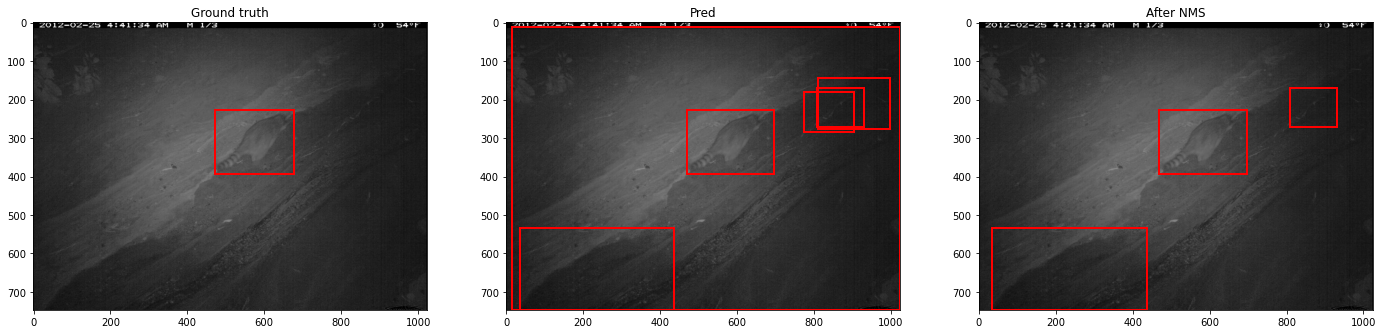

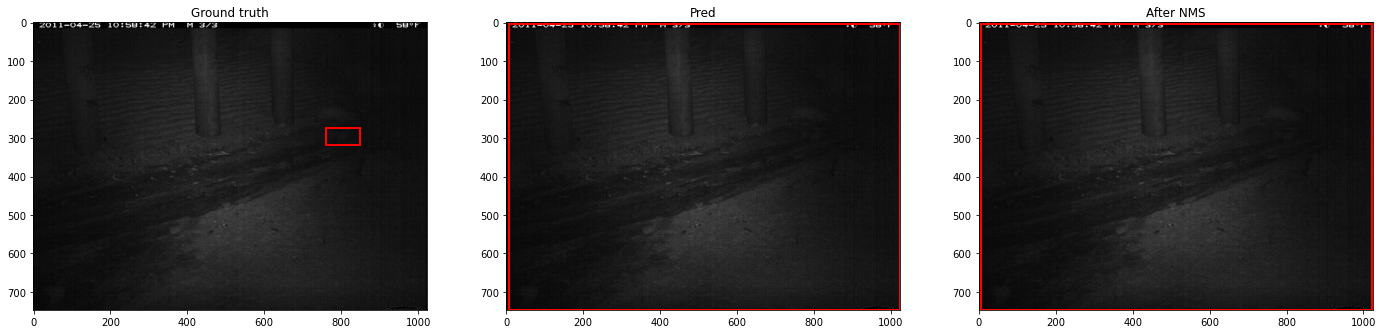

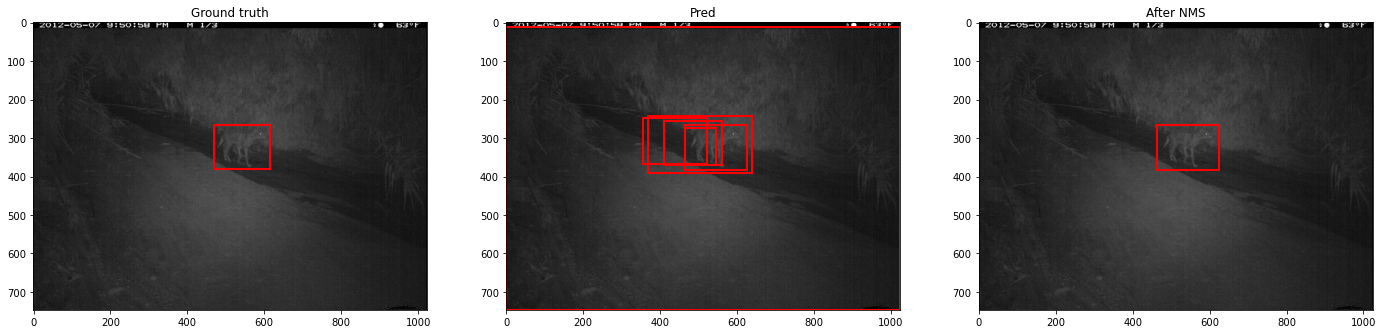

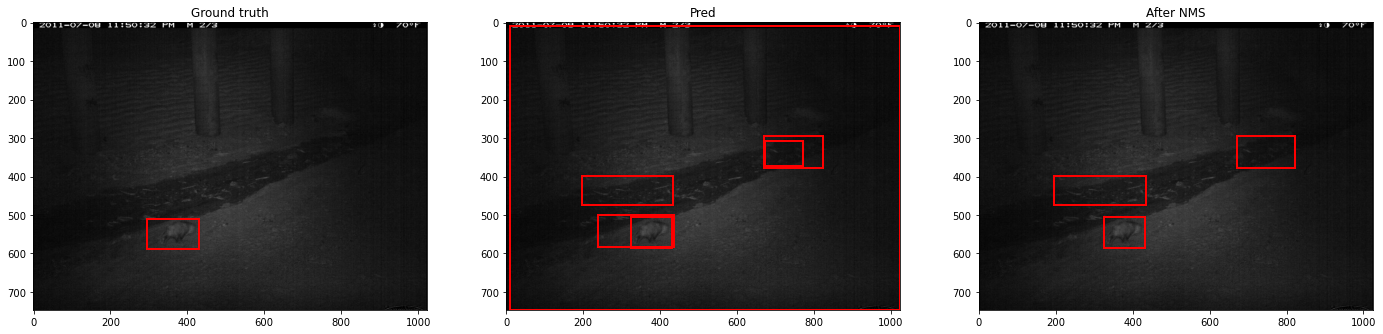

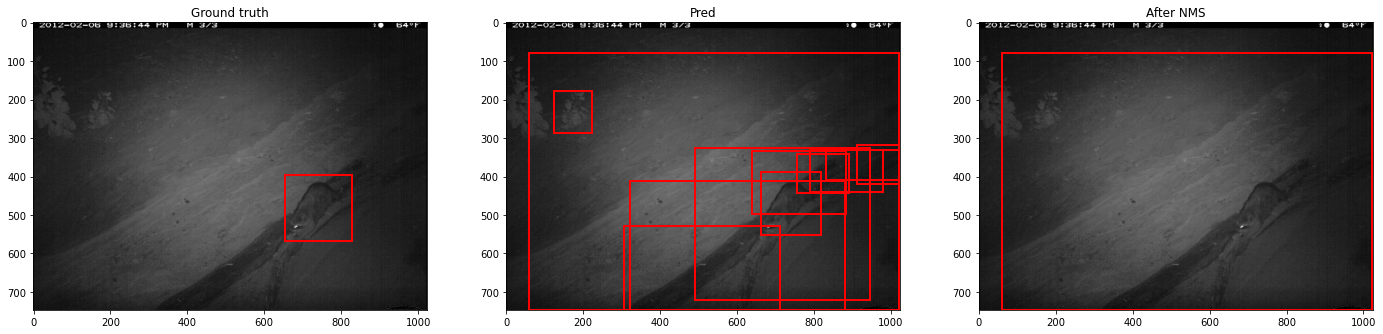

In [72]:
# Prints 10 images with the predictions before and after NMS
for image_i in range(len(image)):
    fig, ax = plt.subplots(1,3,figsize=(24,16))

    ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                              train_labels[image_i]['boxes'][0][1]), 
                             train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                             train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[0].add_patch(rect)
    ax[0].set_title('Ground truth')

    # Predictions
    ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in range(len(pred[image_i]['boxes'])):
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[1].add_patch(rect)
    ax[1].set_title('Pred')

    # Predictions after NMS
    iou_threshold = 0.01 # param to tune
    boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
    ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
    for i in boxes_to_keep:
        rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                                  pred[image_i]['boxes'][i][1].cpu()), 
                                 (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                                 (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax[2].add_patch(rect)

    ax[2].set_title('After NMS')

In [ ]:
# Print a single image chosen by index from the last batch of 10 predictions
image_i = 0 # from 0 to 9 included

fig, ax = plt.subplots(1,3,figsize=(24,16))

ax[0].imshow(train_features[image_i][0].squeeze(),cmap="gray")
rect = patches.Rectangle((train_labels[image_i]['boxes'][0][0], 
                          train_labels[image_i]['boxes'][0][1]), 
                         train_labels[image_i]['boxes'][0][2]-train_labels[image_i]['boxes'][0][0], 
                         train_labels[image_i]['boxes'][0][3]-train_labels[image_i]['boxes'][0][1], 
                         linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)
ax[0].set_title('Ground truth')

# Predictions
ax[1].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in range(len(pred[image_i]['boxes'])):
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect)
ax[1].set_title('Pred')

# Predictions after NMS
iou_threshold = 0.01 # param to tune
boxes_to_keep = torchvision.ops.nms(pred[image_i]['boxes'], pred[image_i]['scores'], iou_threshold = iou_threshold).cpu()
ax[2].imshow(train_features[image_i][0].squeeze(),cmap="gray")
for i in boxes_to_keep:
    rect = patches.Rectangle((pred[image_i]['boxes'][i][0].cpu(), 
                              pred[image_i]['boxes'][i][1].cpu()), 
                             (pred[image_i]['boxes'][i][2]-pred[image_i]['boxes'][i][0]).cpu(), 
                             (pred[image_i]['boxes'][i][3]-pred[image_i]['boxes'][i][1]).cpu(), 
                             linewidth=2, edgecolor='r', facecolor='none')
    ax[2].add_patch(rect)

ax[2].set_title('After NMS')

In [ ]:
boxes_to_keep

In [ ]:
pred[image_i]['boxes'][0]

In [ ]:
train_labels[image_i]['boxes']

## Evalutate on COCO detection metrics

### Cis Test on COCO metrics
##### 'For evaluation, we consider a detected box to be correct if its IoU ≥ 0.5 with a ground truth box.'

We need to look at the precison score with IoU=0.5, area=all and maxDets=100.
For the recall score, by default it's IoU=0.5:IoU=0.95.

In [73]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on cis_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = cis_test_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Cis Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=1.79s).
____________________
Cis Test Data - Summary
 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.470
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.827
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.466
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.247
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.499
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.562
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.048
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=med

### Trans Test on COCO metrics

In [99]:
for param in model.roi_heads.box_predictor.cls_score[0].parameters():
    print(param)

Parameter containing:
tensor([[ 0.0413, -0.0313,  0.0029,  ...,  0.0498, -0.0530,  0.0300],
        [ 0.0389,  0.0486, -0.0524,  ...,  0.0604,  0.0253,  0.0567],
        [-0.0122,  0.0106, -0.0348,  ..., -0.0048, -0.0315, -0.0078],
        ...,
        [ 0.0319,  0.0358, -0.0056,  ..., -0.0334,  0.0080, -0.0084],
        [ 0.0226,  0.0378, -0.0103,  ..., -0.0037, -0.0294, -0.0137],
        [ 0.0444,  0.0141, -0.0174,  ...,  0.0090, -0.0329, -0.0036]],
       device='cuda:0')


In [115]:
np.array(list(model.roi_heads.box_predictor.cls_score[0].weight.cpu().numpy() == X_target_proj.float().numpy())).all()

True

In [85]:
model.roi_heads.box_predictor.cls_score[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False) 
model.roi_heads.box_predictor.bbox_pred[0].weight = nn.Parameter(X_target_proj.float(), requires_grad = False)
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [86]:
# Evaluate perfo on COCO detection metrics

# takes +- 25min to run on trans_test

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
from engine import _get_iou_types 

apply_nms = True
iou_threshold = 0.35 # param to potentially tune
the_data_loader = trans_test_dataloader # change to test set

coco = get_coco_api_from_dataset(the_data_loader.dataset)
iou_types = _get_iou_types(model)
coco_evaluator = CocoEvaluator(coco, iou_types)

model.eval()

for images, targets in the_data_loader:
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    with torch.no_grad():

        pred=model(images)

        if apply_nms:
            boxes_to_keep = torchvision.ops.nms(pred[0]['boxes'], pred[0]['scores'], iou_threshold=iou_threshold).cpu()
            pred[0]['boxes'] = pred[0]['boxes'][boxes_to_keep]
            pred[0]['labels'] = pred[0]['labels'][boxes_to_keep]
            pred[0]['scores'] = pred[0]['scores'][boxes_to_keep]

        outputs = [{k: v.cpu() for k, v in t.items()} for t in pred]
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        coco_evaluator.update(res)

coco_evaluator.synchronize_between_processes()
coco_evaluator.accumulate()
print('_'*20)
print('Trans Test Data - Summary')
print(" ")
coco_evaluator.summarize()

creating index...
index created!
Accumulating evaluation results...
DONE (t=3.65s).
____________________
Trans Test Data - Summary
 
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.421
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.755
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.458
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.466
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.552
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.131
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

# Methods

## Method 3 (Subspace alignment based Domain adaptation)

In [28]:
import torchvision.ops.boxes as bops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch import nn

Papers 

 1. https://arxiv.org/pdf/1507.05578.pdf

 2.  https://openaccess.thecvf.com/content_iccv_2013/papers/Fernando_Unsupervised_Visual_Domain_2013_ICCV_paper.pdf

**Construct source matrix:** 

We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, it has to have a IoU > thres_IoU with the ground truth of the given image. 

In [ ]:
# 20 minutes
thres_IoU= 0.50
count=0

X_source=torch.tensor([])
bbox_idx=torch.arange(1000)

model.eval()

for images, targets in train_dataloader: 
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():
        outputs = []
        hook = model.rpn.register_forward_hook(
        lambda self, input, output: outputs.append(output))

        outputs1 = []
        hook1 = model.roi_heads.box_head.register_forward_hook(
        lambda self, input, output: outputs1.append(output))

        res = model(images)
        hook.remove()
        hook1.remove()

    coords = outputs[0][0][0].cpu() # [1000,4]
    feat=outputs1[0].cpu() # [1000, 1024]

    gt = targets[0]['boxes'].cpu()

    bbox_idx_to_keep=torch.tensor([])
    for i in range(gt.shape[0]):

        IoUs=bops.box_iou(gt[i].reshape(1,4), coords)
        IoUs = IoUs.reshape(1000)
        bbox_idx_to_keep = torch.cat((bbox_idx_to_keep, bbox_idx[IoUs >= thres_IoU]),dim=0)

    X_source = torch.cat((X_source,feat[torch.unique(bbox_idx_to_keep).long()]), dim=0)

In [ ]:
X_source.shape

### Save 1

In [ ]:
torch.save(X_source, 'saved_data/X_source_05_roi.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_source_scaled = scaler.fit_transform(X_source)

In [ ]:
# Apply PCA, keep only the first 100 components which gives the Projected source matrix

pca = PCA(n_components=100)
pca.fit(X_source_scaled)

X_source_proj = pca.components_
X_source_proj = torch.from_numpy(X_source_proj)


In [ ]:
X_source_proj.shape

In [ ]:
plt.plot(pca.explained_variance_ratio_) 
plt.grid()

### Save 2

In [ ]:
torch.save(X_source_proj, 'saved_data/X_source_proj_05_roi.pt')

### Target data with batch size 1

In [ ]:
# Target data/distribution = trans test set - Batch Size 1
trans_test_batch1_img,_ = get_img_with_bbox(trans_test_ann_path)
trans_test_batch1_data = CustomImageDataset(trans_test_ann_path, img_folder, trans_test_batch1_img)
trans_test_batch1_dataloader = DataLoader(trans_test_batch1_data, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

 **Construct target matrix:** 
 
We keep output of model.roi_heads.box_head (vector of size 1024) as feature representations of bounding boxes
 extracted by the RPN (region proposal network). For us to stack a box representation to the source matrix, the predicted bbox associated with the feature has to have a confidence score > thres_conf_score (since we don't use target labels we can't use the IoU here).


In [ ]:
# 30 minutes
thres_conf_score= 0.50 
count=0

X_target=torch.tensor([])

model.eval()

for images, targets in trans_test_batch1_dataloader: # trans location valid AND test ?
    images = [image.to(device) for image in images]
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    count+=1

    if count%100==0:
        print(count)

    with torch.no_grad():

        outputs = []
        hook = model.backbone.register_forward_hook(
        lambda self, input, output: outputs.append(output))
        res = model(images)
        hook.remove()

        box_features = model.roi_heads.box_roi_pool(outputs[0], [r['boxes'] for r in res], [i.shape[-2:] for i in images])
        box_features = model.roi_heads.box_head(box_features)

    X_target = torch.cat((X_target,box_features[res[0]['scores']>=thres_conf_score].cpu()), dim=0)


In [ ]:
X_target.shape

In [ ]:
torch.save(X_target, 'saved_data/X_target_05_roi.pt')

In [ ]:
# center data
scaler = StandardScaler()
X_target_scaled = scaler.fit_transform(X_target)

In [ ]:
# Apply PCA, keep only the first 100 components which gives the Projected source matrix

pca_proj = PCA(n_components=100)
pca_proj.fit(X_target_scaled)

X_target_proj = pca_proj.components_
X_target_proj = torch.from_numpy(X_target_proj)

In [ ]:
plt.plot(pca_proj.explained_variance_ratio_) # we keep 100 dimensions
plt.grid()

In [ ]:
X_target_proj.shape

In [ ]:
torch.save(X_target_proj, 'saved_data/X_target_proj_05_roi.pt')

### Transformation matrix M

𝑀 is obtained by minimizing the following Bregman matrix divergence (following closed-form solution given in the paper)

In [ ]:
M = torch.matmul(X_source_proj, X_target_proj.T) 

In [ ]:
M.shape

### Project source data into target aligned source subspace

In [ ]:
Xa= torch.matmul(X_source_proj.T,M)

In [ ]:
Xa.shape

In [ ]:
# To project a given feature

# feat(1,1024) x Xa (1024,100)

### Projet target data in target subspace

In [ ]:
# To project a given feature

# feat(1,1024) x X_target_proj.T (1024,100)

### Train adapted model

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [30]:
# Loda because it takes time to generate the following matrices so they are saved
X_source_proj = torch.load('saved_data/X_source_proj_05_roi.pt')
X_target_proj = torch.load('saved_data/X_target_proj_05_roi.pt')

In [31]:
X_source_proj.device

device(type='cpu')

In [32]:
M = torch.matmul(X_source_proj, X_target_proj.T) # transformation matrix
print(M.shape)

Xa = torch.matmul(X_source_proj.T,M) # target aligned source subspace
print(Xa.shape)

torch.Size([100, 100])
torch.Size([1024, 100])


In [33]:
M.to(device)

tensor([[-8.3206e-02,  8.6303e-01,  1.4386e-01,  ...,  1.8172e-02,
          8.6311e-03,  2.3675e-03],
        [ 7.7480e-01,  1.3245e-01, -7.4946e-03,  ...,  4.0069e-03,
          4.4142e-03, -1.6273e-02],
        [-1.7604e-01,  1.6074e-01,  3.3943e-01,  ..., -5.0102e-02,
         -4.0499e-02,  6.5427e-04],
        ...,
        [ 2.1474e-03,  1.2598e-03, -1.7591e-03,  ...,  3.9705e-02,
         -4.7052e-02, -4.1430e-02],
        [-1.1055e-02,  5.6693e-04,  1.3001e-02,  ..., -1.9011e-02,
         -7.1657e-02, -5.2998e-02],
        [ 1.4891e-02, -2.4838e-03,  3.5215e-03,  ..., -8.3762e-02,
         -6.9656e-02, -2.7392e-02]], device='cuda:0', dtype=torch.float64)

In [34]:
Xa.to(device)

tensor([[ 0.0357,  0.0360, -0.0238,  ...,  0.0073, -0.0138,  0.0083],
        [-0.0327,  0.0501,  0.0064,  ...,  0.0173,  0.0304,  0.0372],
        [-0.0044, -0.0373, -0.0271,  ..., -0.0026,  0.0218, -0.0077],
        ...,
        [ 0.0277,  0.0458, -0.0143,  ..., -0.0438, -0.0245,  0.0184],
        [-0.0575,  0.0260, -0.0327,  ...,  0.0186, -0.0134, -0.0029],
        [ 0.0359,  0.0597, -0.0025,  ...,  0.0019, -0.0027,  0.0059]],
       device='cuda:0', dtype=torch.float64)

In [53]:
class FastRCNNPredictor_custom(nn.Module):
    """
    Standard classification + bounding box regression layers
    for Fast R-CNN.

    Args:
        in_channels (int): number of input channels
        num_classes (int): number of output classes (including background)
    """

    def __init__(self, in_channels, num_classes, m_transfo):
        super(FastRCNNPredictor_custom, self).__init__()
        self.cls_score = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes))
        self.bbox_pred = nn.Sequential(nn.Linear(in_features = 1024, out_features = 100, bias=False), nn.Linear(in_channels, num_classes * 4))
        self.cls_score[0].weight= nn.Parameter(m_transfo, requires_grad = False)
        self.bbox_pred[0].weight= nn.Parameter(m_transfo, requires_grad = False)

    def forward(self, x):
        if x.dim() == 4:
            assert list(x.shape[2:]) == [1, 1]
        x = x.flatten(start_dim=1)
        scores = self.cls_score(x)
        bbox_deltas = self.bbox_pred(x)

        return scores, bbox_deltas


In [54]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_model_from_pretrained(num_classes)

# move model to the right device
model.to(device)

# load fine-tuned weights
model.load_state_dict(torch.load('saved_models/25_roi_model.pt'))


for param in model.parameters(): # to freeze all existing weights

    param.requires_grad = False

# vector are of size 100 after the transformation
model.roi_heads.box_predictor = FastRCNNPredictor_custom(in_channels=100, num_classes=2, m_transfo=Xa.T.float()) 

# move model to the right device
model.to(device)

# construct an optimizer
# We will only retrain model.roi_heads.box_predictor (2 last layers)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0003, momentum=0.9)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,milestones=[5,10], gamma=0.1)

In [55]:
# weights to learn
for i in range(4):

    print(params[i].shape)

torch.Size([2, 100])
torch.Size([2])
torch.Size([8, 100])
torch.Size([8])


In [56]:
# TRAIN

all_train_logs=[]
all_trans_valid_logs=[]
all_cis_valid_logs=[]

num_epochs = 15

for epoch in range(num_epochs):
    
    # train for one epoch, printing every 100 images
    train_logs = train_one_epoch(model, optimizer, train_dataloader, device, epoch, print_freq=100)
    all_train_logs.append(train_logs)
    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset

    for images, targets in trans_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            trans_loss_dict = model(images, targets)
            trans_loss_dict= [{k: loss.to('cpu')} for k, loss in trans_loss_dict.items()]
            all_trans_valid_logs.append(trans_loss_dict)


    for images, targets in cis_valid_dataloader: # can do batch of 10 prob.
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            cis_loss_dict = model(images, targets)
            cis_loss_dict= [{k: loss.to('cpu')} for k, loss in cis_loss_dict.items()]
            all_cis_valid_logs.append(cis_loss_dict)


C:\Users\kevin\miniconda3\envs\animals\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [    0/12099]  eta: 3:46:16  lr: 0.000001  loss: 0.6835 (0.6835)  loss_classifier: 0.4782 (0.4782)  loss_box_reg: 0.2016 (0.2016)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.1221  data: 0.0355  max mem: 1064
Epoch: [0]  [  100/12099]  eta: 0:27:05  lr: 0.000031  loss: 0.4748 (0.5495)  loss_classifier: 0.2551 (0.3614)  loss_box_reg: 0.1492 (0.1482)  loss_objectness: 0.0066 (0.0327)  loss_rpn_box_reg: 0.0023 (0.0073)  time: 0.1245  data: 0.0352  max mem: 1064
Epoch: [0]  [  200/12099]  eta: 0:25:38  lr: 0.000061  loss: 0.2541 (0.4354)  loss_classifier: 0.1074 (0.2555)  loss_box_reg: 0.1258 (0.1414)  loss_objectness: 0.0053 (0.0321)  loss_rpn_box_reg: 0.0018 (0.0064)  time: 0.1199  data: 0.0329  max mem: 1064
Epoch: [0]  [  300/12099]  eta: 0:25:44  lr: 0.000091  loss: 0.2734 (0.3846)  loss_classifier: 0.0997 (0.2051)  loss_box_reg: 0.1204 (0.1381)  loss_objectness: 0.0099 (0.0343)  loss_rpn_box_reg: 0.0035 (0.0072)  time: 0.1307  data: 0.0357

Epoch: [0]  [ 3300/12099]  eta: 0:19:37  lr: 0.000300  loss: 0.1041 (0.2035)  loss_classifier: 0.0288 (0.0618)  loss_box_reg: 0.0642 (0.0987)  loss_objectness: 0.0052 (0.0350)  loss_rpn_box_reg: 0.0030 (0.0080)  time: 0.1277  data: 0.0344  max mem: 1064
Epoch: [0]  [ 3400/12099]  eta: 0:19:24  lr: 0.000300  loss: 0.1323 (0.2014)  loss_classifier: 0.0341 (0.0610)  loss_box_reg: 0.0525 (0.0975)  loss_objectness: 0.0113 (0.0349)  loss_rpn_box_reg: 0.0030 (0.0081)  time: 0.1418  data: 0.0413  max mem: 1064
Epoch: [0]  [ 3500/12099]  eta: 0:19:12  lr: 0.000300  loss: 0.1107 (0.1994)  loss_classifier: 0.0280 (0.0602)  loss_box_reg: 0.0593 (0.0965)  loss_objectness: 0.0085 (0.0347)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1405  data: 0.0394  max mem: 1064
Epoch: [0]  [ 3600/12099]  eta: 0:18:59  lr: 0.000300  loss: 0.1078 (0.1973)  loss_classifier: 0.0228 (0.0593)  loss_box_reg: 0.0548 (0.0955)  loss_objectness: 0.0062 (0.0346)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1423  data: 0.0408

Epoch: [0]  [ 6600/12099]  eta: 0:12:54  lr: 0.000300  loss: 0.1110 (0.1656)  loss_classifier: 0.0248 (0.0470)  loss_box_reg: 0.0475 (0.0766)  loss_objectness: 0.0126 (0.0341)  loss_rpn_box_reg: 0.0033 (0.0081)  time: 0.1532  data: 0.0429  max mem: 1064
Epoch: [0]  [ 6700/12099]  eta: 0:12:41  lr: 0.000300  loss: 0.1095 (0.1650)  loss_classifier: 0.0225 (0.0467)  loss_box_reg: 0.0432 (0.0762)  loss_objectness: 0.0117 (0.0340)  loss_rpn_box_reg: 0.0046 (0.0081)  time: 0.1415  data: 0.0405  max mem: 1064
Epoch: [0]  [ 6800/12099]  eta: 0:12:28  lr: 0.000300  loss: 0.0944 (0.1645)  loss_classifier: 0.0257 (0.0465)  loss_box_reg: 0.0583 (0.0759)  loss_objectness: 0.0073 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1592  data: 0.0491  max mem: 1064
Epoch: [0]  [ 6900/12099]  eta: 0:12:14  lr: 0.000300  loss: 0.1342 (0.1641)  loss_classifier: 0.0341 (0.0463)  loss_box_reg: 0.0539 (0.0755)  loss_objectness: 0.0042 (0.0341)  loss_rpn_box_reg: 0.0036 (0.0081)  time: 0.1659  data: 0.0521

Epoch: [0]  [ 9900/12099]  eta: 0:05:18  lr: 0.000300  loss: 0.1121 (0.1516)  loss_classifier: 0.0302 (0.0415)  loss_box_reg: 0.0404 (0.0683)  loss_objectness: 0.0070 (0.0338)  loss_rpn_box_reg: 0.0044 (0.0080)  time: 0.1446  data: 0.0409  max mem: 1064
Epoch: [0]  [10000/12099]  eta: 0:05:04  lr: 0.000300  loss: 0.1088 (0.1512)  loss_classifier: 0.0248 (0.0413)  loss_box_reg: 0.0567 (0.0681)  loss_objectness: 0.0034 (0.0338)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1503  data: 0.0439  max mem: 1064
Epoch: [0]  [10100/12099]  eta: 0:04:49  lr: 0.000300  loss: 0.1015 (0.1508)  loss_classifier: 0.0256 (0.0413)  loss_box_reg: 0.0427 (0.0679)  loss_objectness: 0.0083 (0.0337)  loss_rpn_box_reg: 0.0035 (0.0080)  time: 0.1380  data: 0.0382  max mem: 1064
Epoch: [0]  [10200/12099]  eta: 0:04:35  lr: 0.000300  loss: 0.1114 (0.1504)  loss_classifier: 0.0229 (0.0411)  loss_box_reg: 0.0362 (0.0677)  loss_objectness: 0.0208 (0.0337)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1421  data: 0.0393

Epoch: [1]  [ 1000/12099]  eta: 0:25:59  lr: 0.000300  loss: 0.0949 (0.1157)  loss_classifier: 0.0253 (0.0288)  loss_box_reg: 0.0542 (0.0489)  loss_objectness: 0.0061 (0.0310)  loss_rpn_box_reg: 0.0016 (0.0069)  time: 0.1412  data: 0.0403  max mem: 4294
Epoch: [1]  [ 1100/12099]  eta: 0:25:41  lr: 0.000300  loss: 0.1116 (0.1164)  loss_classifier: 0.0212 (0.0288)  loss_box_reg: 0.0446 (0.0489)  loss_objectness: 0.0255 (0.0314)  loss_rpn_box_reg: 0.0035 (0.0073)  time: 0.1511  data: 0.0473  max mem: 4294
Epoch: [1]  [ 1200/12099]  eta: 0:25:24  lr: 0.000300  loss: 0.1049 (0.1172)  loss_classifier: 0.0210 (0.0287)  loss_box_reg: 0.0517 (0.0494)  loss_objectness: 0.0048 (0.0316)  loss_rpn_box_reg: 0.0036 (0.0075)  time: 0.1431  data: 0.0446  max mem: 4294
Epoch: [1]  [ 1300/12099]  eta: 0:25:07  lr: 0.000300  loss: 0.0759 (0.1174)  loss_classifier: 0.0222 (0.0287)  loss_box_reg: 0.0357 (0.0493)  loss_objectness: 0.0086 (0.0319)  loss_rpn_box_reg: 0.0026 (0.0074)  time: 0.1338  data: 0.0365

Epoch: [1]  [ 4300/12099]  eta: 0:17:49  lr: 0.000300  loss: 0.0877 (0.1188)  loss_classifier: 0.0216 (0.0286)  loss_box_reg: 0.0344 (0.0494)  loss_objectness: 0.0121 (0.0329)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1461  data: 0.0437  max mem: 4294
Epoch: [1]  [ 4400/12099]  eta: 0:17:35  lr: 0.000300  loss: 0.0962 (0.1192)  loss_classifier: 0.0150 (0.0287)  loss_box_reg: 0.0375 (0.0495)  loss_objectness: 0.0194 (0.0332)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1325  data: 0.0359  max mem: 4294
Epoch: [1]  [ 4500/12099]  eta: 0:17:20  lr: 0.000300  loss: 0.1093 (0.1195)  loss_classifier: 0.0248 (0.0287)  loss_box_reg: 0.0423 (0.0494)  loss_objectness: 0.0393 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1312  data: 0.0365  max mem: 4294
Epoch: [1]  [ 4600/12099]  eta: 0:17:07  lr: 0.000300  loss: 0.0978 (0.1197)  loss_classifier: 0.0211 (0.0288)  loss_box_reg: 0.0330 (0.0495)  loss_objectness: 0.0061 (0.0336)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1299  data: 0.0354

Epoch: [1]  [ 7600/12099]  eta: 0:10:31  lr: 0.000300  loss: 0.0954 (0.1206)  loss_classifier: 0.0219 (0.0291)  loss_box_reg: 0.0377 (0.0498)  loss_objectness: 0.0055 (0.0339)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1579  data: 0.0480  max mem: 4294
Epoch: [1]  [ 7700/12099]  eta: 0:10:18  lr: 0.000300  loss: 0.1177 (0.1208)  loss_classifier: 0.0194 (0.0291)  loss_box_reg: 0.0453 (0.0498)  loss_objectness: 0.0078 (0.0340)  loss_rpn_box_reg: 0.0074 (0.0079)  time: 0.1435  data: 0.0418  max mem: 4294
Epoch: [1]  [ 7800/12099]  eta: 0:10:03  lr: 0.000300  loss: 0.1277 (0.1207)  loss_classifier: 0.0348 (0.0290)  loss_box_reg: 0.0413 (0.0498)  loss_objectness: 0.0236 (0.0339)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1289  data: 0.0352  max mem: 4294
Epoch: [1]  [ 7900/12099]  eta: 0:09:49  lr: 0.000300  loss: 0.1136 (0.1207)  loss_classifier: 0.0228 (0.0290)  loss_box_reg: 0.0343 (0.0498)  loss_objectness: 0.0052 (0.0340)  loss_rpn_box_reg: 0.0029 (0.0079)  time: 0.1287  data: 0.0358

Epoch: [1]  [10900/12099]  eta: 0:02:48  lr: 0.000300  loss: 0.1210 (0.1199)  loss_classifier: 0.0264 (0.0289)  loss_box_reg: 0.0423 (0.0496)  loss_objectness: 0.0104 (0.0336)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1290  data: 0.0367  max mem: 4294
Epoch: [1]  [11000/12099]  eta: 0:02:34  lr: 0.000300  loss: 0.0918 (0.1199)  loss_classifier: 0.0203 (0.0289)  loss_box_reg: 0.0334 (0.0496)  loss_objectness: 0.0052 (0.0336)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1299  data: 0.0369  max mem: 4294
Epoch: [1]  [11100/12099]  eta: 0:02:20  lr: 0.000300  loss: 0.0806 (0.1198)  loss_classifier: 0.0238 (0.0289)  loss_box_reg: 0.0334 (0.0496)  loss_objectness: 0.0014 (0.0335)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1617  data: 0.0572  max mem: 4294
Epoch: [1]  [11200/12099]  eta: 0:02:06  lr: 0.000300  loss: 0.1000 (0.1197)  loss_classifier: 0.0205 (0.0289)  loss_box_reg: 0.0489 (0.0495)  loss_objectness: 0.0217 (0.0335)  loss_rpn_box_reg: 0.0011 (0.0078)  time: 0.1446  data: 0.0476

Epoch: [2]  [ 2000/12099]  eta: 0:20:07  lr: 0.000300  loss: 0.1134 (0.1162)  loss_classifier: 0.0194 (0.0279)  loss_box_reg: 0.0389 (0.0486)  loss_objectness: 0.0096 (0.0319)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1208  data: 0.0326  max mem: 4294
Epoch: [2]  [ 2100/12099]  eta: 0:19:55  lr: 0.000300  loss: 0.0840 (0.1162)  loss_classifier: 0.0214 (0.0281)  loss_box_reg: 0.0381 (0.0485)  loss_objectness: 0.0047 (0.0318)  loss_rpn_box_reg: 0.0011 (0.0078)  time: 0.1215  data: 0.0332  max mem: 4294
Epoch: [2]  [ 2200/12099]  eta: 0:19:44  lr: 0.000300  loss: 0.1177 (0.1167)  loss_classifier: 0.0238 (0.0280)  loss_box_reg: 0.0521 (0.0484)  loss_objectness: 0.0260 (0.0326)  loss_rpn_box_reg: 0.0024 (0.0077)  time: 0.1217  data: 0.0337  max mem: 4294
Epoch: [2]  [ 2300/12099]  eta: 0:19:31  lr: 0.000300  loss: 0.1038 (0.1170)  loss_classifier: 0.0295 (0.0281)  loss_box_reg: 0.0506 (0.0485)  loss_objectness: 0.0139 (0.0327)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1178  data: 0.0317

Epoch: [2]  [ 5300/12099]  eta: 0:13:52  lr: 0.000300  loss: 0.0975 (0.1178)  loss_classifier: 0.0210 (0.0283)  loss_box_reg: 0.0431 (0.0485)  loss_objectness: 0.0211 (0.0330)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1244  data: 0.0328  max mem: 4294
Epoch: [2]  [ 5400/12099]  eta: 0:13:41  lr: 0.000300  loss: 0.0972 (0.1178)  loss_classifier: 0.0240 (0.0283)  loss_box_reg: 0.0448 (0.0485)  loss_objectness: 0.0045 (0.0330)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1378  data: 0.0410  max mem: 4294
Epoch: [2]  [ 5500/12099]  eta: 0:13:30  lr: 0.000300  loss: 0.1106 (0.1181)  loss_classifier: 0.0215 (0.0283)  loss_box_reg: 0.0590 (0.0485)  loss_objectness: 0.0028 (0.0332)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1294  data: 0.0363  max mem: 4294
Epoch: [2]  [ 5600/12099]  eta: 0:13:18  lr: 0.000300  loss: 0.0989 (0.1178)  loss_classifier: 0.0261 (0.0282)  loss_box_reg: 0.0465 (0.0485)  loss_objectness: 0.0030 (0.0331)  loss_rpn_box_reg: 0.0031 (0.0080)  time: 0.1335  data: 0.0374

Epoch: [2]  [ 8600/12099]  eta: 0:07:19  lr: 0.000300  loss: 0.0921 (0.1182)  loss_classifier: 0.0178 (0.0283)  loss_box_reg: 0.0464 (0.0487)  loss_objectness: 0.0105 (0.0334)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1342  data: 0.0378  max mem: 4294
Epoch: [2]  [ 8700/12099]  eta: 0:07:07  lr: 0.000300  loss: 0.0806 (0.1181)  loss_classifier: 0.0176 (0.0282)  loss_box_reg: 0.0297 (0.0486)  loss_objectness: 0.0061 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1279  data: 0.0358  max mem: 4294
Epoch: [2]  [ 8800/12099]  eta: 0:06:54  lr: 0.000300  loss: 0.1180 (0.1180)  loss_classifier: 0.0249 (0.0282)  loss_box_reg: 0.0512 (0.0486)  loss_objectness: 0.0255 (0.0333)  loss_rpn_box_reg: 0.0050 (0.0079)  time: 0.1332  data: 0.0383  max mem: 4294
Epoch: [2]  [ 8900/12099]  eta: 0:06:42  lr: 0.000300  loss: 0.1048 (0.1179)  loss_classifier: 0.0228 (0.0282)  loss_box_reg: 0.0386 (0.0485)  loss_objectness: 0.0206 (0.0333)  loss_rpn_box_reg: 0.0055 (0.0079)  time: 0.1327  data: 0.0367

Epoch: [2]  [11900/12099]  eta: 0:00:25  lr: 0.000300  loss: 0.1308 (0.1181)  loss_classifier: 0.0262 (0.0282)  loss_box_reg: 0.0464 (0.0486)  loss_objectness: 0.0049 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1289  data: 0.0366  max mem: 4294
Epoch: [2]  [12000/12099]  eta: 0:00:12  lr: 0.000300  loss: 0.1426 (0.1182)  loss_classifier: 0.0274 (0.0282)  loss_box_reg: 0.0434 (0.0486)  loss_objectness: 0.0060 (0.0334)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1333  data: 0.0370  max mem: 4294
Epoch: [2]  [12098/12099]  eta: 0:00:00  lr: 0.000300  loss: 0.0800 (0.1181)  loss_classifier: 0.0225 (0.0282)  loss_box_reg: 0.0388 (0.0486)  loss_objectness: 0.0040 (0.0334)  loss_rpn_box_reg: 0.0016 (0.0079)  time: 0.1267  data: 0.0337  max mem: 4294
Epoch: [2] Total time: 0:25:22 (0.1258 s / it)
Epoch: [3]  [    0/12099]  eta: 0:24:48  lr: 0.000300  loss: 0.1486 (0.1486)  loss_classifier: 0.0462 (0.0462)  loss_box_reg: 0.0735 (0.0735)  loss_objectness: 0.0278 (0.0278)  loss_rpn_box_r

Epoch: [3]  [ 3000/12099]  eta: 0:20:14  lr: 0.000300  loss: 0.0777 (0.1166)  loss_classifier: 0.0217 (0.0276)  loss_box_reg: 0.0412 (0.0480)  loss_objectness: 0.0037 (0.0328)  loss_rpn_box_reg: 0.0033 (0.0081)  time: 0.1535  data: 0.0448  max mem: 4294
Epoch: [3]  [ 3100/12099]  eta: 0:20:06  lr: 0.000300  loss: 0.0978 (0.1165)  loss_classifier: 0.0168 (0.0276)  loss_box_reg: 0.0418 (0.0481)  loss_objectness: 0.0107 (0.0327)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 0.1511  data: 0.0435  max mem: 4294
Epoch: [3]  [ 3200/12099]  eta: 0:19:58  lr: 0.000300  loss: 0.0950 (0.1167)  loss_classifier: 0.0196 (0.0275)  loss_box_reg: 0.0404 (0.0481)  loss_objectness: 0.0210 (0.0329)  loss_rpn_box_reg: 0.0045 (0.0081)  time: 0.1548  data: 0.0460  max mem: 4294
Epoch: [3]  [ 3300/12099]  eta: 0:19:51  lr: 0.000300  loss: 0.0911 (0.1165)  loss_classifier: 0.0238 (0.0276)  loss_box_reg: 0.0489 (0.0482)  loss_objectness: 0.0015 (0.0327)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1606  data: 0.0486

Epoch: [3]  [ 6300/12099]  eta: 0:13:37  lr: 0.000300  loss: 0.0847 (0.1175)  loss_classifier: 0.0208 (0.0280)  loss_box_reg: 0.0372 (0.0486)  loss_objectness: 0.0034 (0.0330)  loss_rpn_box_reg: 0.0017 (0.0080)  time: 0.1531  data: 0.0448  max mem: 4294
Epoch: [3]  [ 6400/12099]  eta: 0:13:24  lr: 0.000300  loss: 0.1080 (0.1175)  loss_classifier: 0.0308 (0.0280)  loss_box_reg: 0.0467 (0.0486)  loss_objectness: 0.0060 (0.0329)  loss_rpn_box_reg: 0.0037 (0.0080)  time: 0.1496  data: 0.0433  max mem: 4294
Epoch: [3]  [ 6500/12099]  eta: 0:13:09  lr: 0.000300  loss: 0.0895 (0.1179)  loss_classifier: 0.0253 (0.0279)  loss_box_reg: 0.0371 (0.0485)  loss_objectness: 0.0053 (0.0333)  loss_rpn_box_reg: 0.0022 (0.0080)  time: 0.1354  data: 0.0373  max mem: 4294
Epoch: [3]  [ 6600/12099]  eta: 0:12:57  lr: 0.000300  loss: 0.1420 (0.1180)  loss_classifier: 0.0222 (0.0279)  loss_box_reg: 0.0392 (0.0485)  loss_objectness: 0.0270 (0.0334)  loss_rpn_box_reg: 0.0030 (0.0081)  time: 0.1824  data: 0.0580

Epoch: [3]  [ 9600/12099]  eta: 0:05:56  lr: 0.000300  loss: 0.1293 (0.1177)  loss_classifier: 0.0196 (0.0279)  loss_box_reg: 0.0359 (0.0482)  loss_objectness: 0.0169 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1331  data: 0.0375  max mem: 4294
Epoch: [3]  [ 9700/12099]  eta: 0:05:42  lr: 0.000300  loss: 0.0946 (0.1176)  loss_classifier: 0.0263 (0.0279)  loss_box_reg: 0.0476 (0.0482)  loss_objectness: 0.0020 (0.0335)  loss_rpn_box_reg: 0.0026 (0.0080)  time: 0.1449  data: 0.0447  max mem: 4294
Epoch: [3]  [ 9800/12099]  eta: 0:05:27  lr: 0.000300  loss: 0.0780 (0.1176)  loss_classifier: 0.0192 (0.0279)  loss_box_reg: 0.0302 (0.0482)  loss_objectness: 0.0070 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0080)  time: 0.1509  data: 0.0470  max mem: 4294
Epoch: [3]  [ 9900/12099]  eta: 0:05:13  lr: 0.000300  loss: 0.0957 (0.1176)  loss_classifier: 0.0214 (0.0279)  loss_box_reg: 0.0407 (0.0482)  loss_objectness: 0.0068 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1411  data: 0.0398

Epoch: [4]  [  700/12099]  eta: 0:28:34  lr: 0.000300  loss: 0.1113 (0.1150)  loss_classifier: 0.0211 (0.0273)  loss_box_reg: 0.0366 (0.0462)  loss_objectness: 0.0174 (0.0332)  loss_rpn_box_reg: 0.0031 (0.0082)  time: 0.1473  data: 0.0443  max mem: 4294
Epoch: [4]  [  800/12099]  eta: 0:28:06  lr: 0.000300  loss: 0.0903 (0.1139)  loss_classifier: 0.0240 (0.0276)  loss_box_reg: 0.0475 (0.0467)  loss_objectness: 0.0058 (0.0316)  loss_rpn_box_reg: 0.0019 (0.0080)  time: 0.1294  data: 0.0388  max mem: 4294
Epoch: [4]  [  900/12099]  eta: 0:27:27  lr: 0.000300  loss: 0.0885 (0.1145)  loss_classifier: 0.0205 (0.0273)  loss_box_reg: 0.0406 (0.0465)  loss_objectness: 0.0062 (0.0325)  loss_rpn_box_reg: 0.0029 (0.0081)  time: 0.1278  data: 0.0370  max mem: 4294
Epoch: [4]  [ 1000/12099]  eta: 0:26:58  lr: 0.000300  loss: 0.0933 (0.1163)  loss_classifier: 0.0189 (0.0275)  loss_box_reg: 0.0498 (0.0469)  loss_objectness: 0.0060 (0.0341)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1265  data: 0.0353

Epoch: [4]  [ 4000/12099]  eta: 0:19:17  lr: 0.000300  loss: 0.0908 (0.1174)  loss_classifier: 0.0229 (0.0276)  loss_box_reg: 0.0435 (0.0473)  loss_objectness: 0.0039 (0.0346)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1355  data: 0.0359  max mem: 4294
Epoch: [4]  [ 4100/12099]  eta: 0:19:01  lr: 0.000300  loss: 0.0861 (0.1169)  loss_classifier: 0.0196 (0.0276)  loss_box_reg: 0.0383 (0.0472)  loss_objectness: 0.0020 (0.0343)  loss_rpn_box_reg: 0.0047 (0.0078)  time: 0.1359  data: 0.0377  max mem: 4294
Epoch: [4]  [ 4200/12099]  eta: 0:18:46  lr: 0.000300  loss: 0.1000 (0.1170)  loss_classifier: 0.0165 (0.0276)  loss_box_reg: 0.0354 (0.0473)  loss_objectness: 0.0178 (0.0342)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1457  data: 0.0435  max mem: 4294
Epoch: [4]  [ 4300/12099]  eta: 0:18:31  lr: 0.000300  loss: 0.0896 (0.1171)  loss_classifier: 0.0259 (0.0277)  loss_box_reg: 0.0395 (0.0474)  loss_objectness: 0.0051 (0.0341)  loss_rpn_box_reg: 0.0018 (0.0078)  time: 0.1311  data: 0.0357

Epoch: [4]  [ 7300/12099]  eta: 0:11:05  lr: 0.000300  loss: 0.0962 (0.1170)  loss_classifier: 0.0208 (0.0277)  loss_box_reg: 0.0434 (0.0476)  loss_objectness: 0.0159 (0.0339)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1245  data: 0.0330  max mem: 4294
Epoch: [4]  [ 7400/12099]  eta: 0:10:50  lr: 0.000300  loss: 0.1061 (0.1171)  loss_classifier: 0.0206 (0.0277)  loss_box_reg: 0.0371 (0.0476)  loss_objectness: 0.0103 (0.0338)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1189  data: 0.0309  max mem: 4294
Epoch: [4]  [ 7500/12099]  eta: 0:10:35  lr: 0.000300  loss: 0.0914 (0.1172)  loss_classifier: 0.0158 (0.0277)  loss_box_reg: 0.0316 (0.0477)  loss_objectness: 0.0138 (0.0338)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1152  data: 0.0317  max mem: 4294
Epoch: [4]  [ 7600/12099]  eta: 0:10:20  lr: 0.000300  loss: 0.0793 (0.1172)  loss_classifier: 0.0250 (0.0277)  loss_box_reg: 0.0515 (0.0477)  loss_objectness: 0.0018 (0.0338)  loss_rpn_box_reg: 0.0014 (0.0080)  time: 0.1221  data: 0.0340

Epoch: [4]  [10600/12099]  eta: 0:03:23  lr: 0.000300  loss: 0.1278 (0.1173)  loss_classifier: 0.0297 (0.0279)  loss_box_reg: 0.0501 (0.0480)  loss_objectness: 0.0083 (0.0335)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1424  data: 0.0416  max mem: 4294
Epoch: [4]  [10700/12099]  eta: 0:03:09  lr: 0.000300  loss: 0.1290 (0.1174)  loss_classifier: 0.0262 (0.0279)  loss_box_reg: 0.0530 (0.0481)  loss_objectness: 0.0116 (0.0336)  loss_rpn_box_reg: 0.0032 (0.0078)  time: 0.1481  data: 0.0464  max mem: 4294
Epoch: [4]  [10800/12099]  eta: 0:02:56  lr: 0.000300  loss: 0.1048 (0.1174)  loss_classifier: 0.0225 (0.0279)  loss_box_reg: 0.0612 (0.0481)  loss_objectness: 0.0026 (0.0336)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1262  data: 0.0341  max mem: 4294
Epoch: [4]  [10900/12099]  eta: 0:02:42  lr: 0.000300  loss: 0.0873 (0.1174)  loss_classifier: 0.0222 (0.0279)  loss_box_reg: 0.0405 (0.0481)  loss_objectness: 0.0017 (0.0335)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1277  data: 0.0376

Epoch: [5]  [ 1700/12099]  eta: 0:23:00  lr: 0.000030  loss: 0.1265 (0.1152)  loss_classifier: 0.0307 (0.0278)  loss_box_reg: 0.0409 (0.0482)  loss_objectness: 0.0188 (0.0320)  loss_rpn_box_reg: 0.0033 (0.0072)  time: 0.1349  data: 0.0383  max mem: 4294
Epoch: [5]  [ 1800/12099]  eta: 0:22:49  lr: 0.000030  loss: 0.0902 (0.1146)  loss_classifier: 0.0227 (0.0277)  loss_box_reg: 0.0293 (0.0482)  loss_objectness: 0.0113 (0.0314)  loss_rpn_box_reg: 0.0042 (0.0073)  time: 0.1497  data: 0.0448  max mem: 4294
Epoch: [5]  [ 1900/12099]  eta: 0:22:41  lr: 0.000030  loss: 0.1099 (0.1149)  loss_classifier: 0.0199 (0.0277)  loss_box_reg: 0.0333 (0.0482)  loss_objectness: 0.0207 (0.0316)  loss_rpn_box_reg: 0.0055 (0.0075)  time: 0.1488  data: 0.0476  max mem: 4294
Epoch: [5]  [ 2000/12099]  eta: 0:22:35  lr: 0.000030  loss: 0.0847 (0.1151)  loss_classifier: 0.0239 (0.0278)  loss_box_reg: 0.0363 (0.0484)  loss_objectness: 0.0031 (0.0316)  loss_rpn_box_reg: 0.0019 (0.0074)  time: 0.1572  data: 0.0469

Epoch: [5]  [ 5000/12099]  eta: 0:16:15  lr: 0.000030  loss: 0.0799 (0.1164)  loss_classifier: 0.0207 (0.0278)  loss_box_reg: 0.0438 (0.0482)  loss_objectness: 0.0068 (0.0327)  loss_rpn_box_reg: 0.0019 (0.0077)  time: 0.1427  data: 0.0410  max mem: 4294
Epoch: [5]  [ 5100/12099]  eta: 0:16:01  lr: 0.000030  loss: 0.1047 (0.1163)  loss_classifier: 0.0213 (0.0278)  loss_box_reg: 0.0422 (0.0483)  loss_objectness: 0.0114 (0.0326)  loss_rpn_box_reg: 0.0030 (0.0077)  time: 0.1272  data: 0.0348  max mem: 4294
Epoch: [5]  [ 5200/12099]  eta: 0:15:47  lr: 0.000030  loss: 0.0939 (0.1164)  loss_classifier: 0.0179 (0.0279)  loss_box_reg: 0.0442 (0.0482)  loss_objectness: 0.0191 (0.0326)  loss_rpn_box_reg: 0.0039 (0.0077)  time: 0.1277  data: 0.0364  max mem: 4294
Epoch: [5]  [ 5300/12099]  eta: 0:15:33  lr: 0.000030  loss: 0.0860 (0.1164)  loss_classifier: 0.0212 (0.0278)  loss_box_reg: 0.0487 (0.0483)  loss_objectness: 0.0068 (0.0325)  loss_rpn_box_reg: 0.0016 (0.0077)  time: 0.1297  data: 0.0357

Epoch: [5]  [ 8300/12099]  eta: 0:08:30  lr: 0.000030  loss: 0.0818 (0.1170)  loss_classifier: 0.0176 (0.0279)  loss_box_reg: 0.0331 (0.0477)  loss_objectness: 0.0091 (0.0335)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1381  data: 0.0391  max mem: 4294
Epoch: [5]  [ 8400/12099]  eta: 0:08:17  lr: 0.000030  loss: 0.1001 (0.1169)  loss_classifier: 0.0178 (0.0279)  loss_box_reg: 0.0397 (0.0477)  loss_objectness: 0.0082 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1322  data: 0.0379  max mem: 4294
Epoch: [5]  [ 8500/12099]  eta: 0:08:03  lr: 0.000030  loss: 0.0816 (0.1170)  loss_classifier: 0.0169 (0.0279)  loss_box_reg: 0.0344 (0.0477)  loss_objectness: 0.0284 (0.0334)  loss_rpn_box_reg: 0.0014 (0.0079)  time: 0.1296  data: 0.0372  max mem: 4294
Epoch: [5]  [ 8600/12099]  eta: 0:07:49  lr: 0.000030  loss: 0.0986 (0.1170)  loss_classifier: 0.0197 (0.0279)  loss_box_reg: 0.0333 (0.0477)  loss_objectness: 0.0059 (0.0334)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1362  data: 0.0382

Epoch: [5]  [11600/12099]  eta: 0:01:05  lr: 0.000030  loss: 0.1209 (0.1167)  loss_classifier: 0.0190 (0.0277)  loss_box_reg: 0.0445 (0.0477)  loss_objectness: 0.0111 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1144  data: 0.0302  max mem: 4294
Epoch: [5]  [11700/12099]  eta: 0:00:52  lr: 0.000030  loss: 0.0920 (0.1167)  loss_classifier: 0.0191 (0.0277)  loss_box_reg: 0.0465 (0.0477)  loss_objectness: 0.0043 (0.0335)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1166  data: 0.0316  max mem: 4294
Epoch: [5]  [11800/12099]  eta: 0:00:39  lr: 0.000030  loss: 0.0776 (0.1166)  loss_classifier: 0.0153 (0.0277)  loss_box_reg: 0.0306 (0.0476)  loss_objectness: 0.0044 (0.0334)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1152  data: 0.0307  max mem: 4294
Epoch: [5]  [11900/12099]  eta: 0:00:26  lr: 0.000030  loss: 0.0564 (0.1166)  loss_classifier: 0.0148 (0.0277)  loss_box_reg: 0.0239 (0.0476)  loss_objectness: 0.0018 (0.0334)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1203  data: 0.0336

Epoch: [6]  [ 2700/12099]  eta: 0:18:01  lr: 0.000030  loss: 0.1450 (0.1179)  loss_classifier: 0.0340 (0.0279)  loss_box_reg: 0.0466 (0.0478)  loss_objectness: 0.0076 (0.0340)  loss_rpn_box_reg: 0.0022 (0.0082)  time: 0.1151  data: 0.0318  max mem: 4294
Epoch: [6]  [ 2800/12099]  eta: 0:17:50  lr: 0.000030  loss: 0.0798 (0.1179)  loss_classifier: 0.0195 (0.0279)  loss_box_reg: 0.0438 (0.0477)  loss_objectness: 0.0024 (0.0340)  loss_rpn_box_reg: 0.0020 (0.0082)  time: 0.1227  data: 0.0353  max mem: 4294
Epoch: [6]  [ 2900/12099]  eta: 0:17:38  lr: 0.000030  loss: 0.1222 (0.1180)  loss_classifier: 0.0220 (0.0278)  loss_box_reg: 0.0424 (0.0477)  loss_objectness: 0.0186 (0.0342)  loss_rpn_box_reg: 0.0033 (0.0082)  time: 0.1152  data: 0.0303  max mem: 4294
Epoch: [6]  [ 3000/12099]  eta: 0:17:27  lr: 0.000030  loss: 0.1176 (0.1181)  loss_classifier: 0.0244 (0.0278)  loss_box_reg: 0.0436 (0.0477)  loss_objectness: 0.0124 (0.0344)  loss_rpn_box_reg: 0.0037 (0.0082)  time: 0.1127  data: 0.0295

Epoch: [6]  [ 6000/12099]  eta: 0:11:41  lr: 0.000030  loss: 0.0833 (0.1177)  loss_classifier: 0.0223 (0.0278)  loss_box_reg: 0.0429 (0.0477)  loss_objectness: 0.0039 (0.0341)  loss_rpn_box_reg: 0.0016 (0.0081)  time: 0.1147  data: 0.0312  max mem: 4294
Epoch: [6]  [ 6100/12099]  eta: 0:11:30  lr: 0.000030  loss: 0.1231 (0.1177)  loss_classifier: 0.0225 (0.0278)  loss_box_reg: 0.0571 (0.0477)  loss_objectness: 0.0108 (0.0341)  loss_rpn_box_reg: 0.0040 (0.0081)  time: 0.1119  data: 0.0289  max mem: 4294
Epoch: [6]  [ 6200/12099]  eta: 0:11:18  lr: 0.000030  loss: 0.1154 (0.1177)  loss_classifier: 0.0249 (0.0278)  loss_box_reg: 0.0379 (0.0477)  loss_objectness: 0.0097 (0.0341)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1134  data: 0.0301  max mem: 4294
Epoch: [6]  [ 6300/12099]  eta: 0:11:07  lr: 0.000030  loss: 0.0831 (0.1176)  loss_classifier: 0.0245 (0.0278)  loss_box_reg: 0.0307 (0.0477)  loss_objectness: 0.0060 (0.0340)  loss_rpn_box_reg: 0.0022 (0.0081)  time: 0.1126  data: 0.0295

Epoch: [6]  [ 9300/12099]  eta: 0:05:24  lr: 0.000030  loss: 0.0998 (0.1168)  loss_classifier: 0.0211 (0.0277)  loss_box_reg: 0.0475 (0.0479)  loss_objectness: 0.0051 (0.0332)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1152  data: 0.0307  max mem: 4294
Epoch: [6]  [ 9400/12099]  eta: 0:05:12  lr: 0.000030  loss: 0.0984 (0.1167)  loss_classifier: 0.0220 (0.0277)  loss_box_reg: 0.0555 (0.0479)  loss_objectness: 0.0034 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1147  data: 0.0308  max mem: 4294
Epoch: [6]  [ 9500/12099]  eta: 0:05:01  lr: 0.000030  loss: 0.0998 (0.1167)  loss_classifier: 0.0199 (0.0277)  loss_box_reg: 0.0414 (0.0479)  loss_objectness: 0.0129 (0.0332)  loss_rpn_box_reg: 0.0041 (0.0079)  time: 0.1156  data: 0.0305  max mem: 4294
Epoch: [6]  [ 9600/12099]  eta: 0:04:49  lr: 0.000030  loss: 0.0797 (0.1166)  loss_classifier: 0.0270 (0.0277)  loss_box_reg: 0.0375 (0.0478)  loss_objectness: 0.0041 (0.0331)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1148  data: 0.0305

Epoch: [7]  [  400/12099]  eta: 0:22:08  lr: 0.000030  loss: 0.1183 (0.1191)  loss_classifier: 0.0253 (0.0269)  loss_box_reg: 0.0257 (0.0463)  loss_objectness: 0.0434 (0.0376)  loss_rpn_box_reg: 0.0043 (0.0082)  time: 0.1134  data: 0.0297  max mem: 4294
Epoch: [7]  [  500/12099]  eta: 0:21:57  lr: 0.000030  loss: 0.0848 (0.1174)  loss_classifier: 0.0157 (0.0265)  loss_box_reg: 0.0348 (0.0459)  loss_objectness: 0.0228 (0.0369)  loss_rpn_box_reg: 0.0017 (0.0080)  time: 0.1123  data: 0.0291  max mem: 4294
Epoch: [7]  [  600/12099]  eta: 0:21:46  lr: 0.000030  loss: 0.1082 (0.1177)  loss_classifier: 0.0220 (0.0269)  loss_box_reg: 0.0354 (0.0461)  loss_objectness: 0.0189 (0.0367)  loss_rpn_box_reg: 0.0040 (0.0080)  time: 0.1125  data: 0.0282  max mem: 4294
Epoch: [7]  [  700/12099]  eta: 0:21:33  lr: 0.000030  loss: 0.0859 (0.1178)  loss_classifier: 0.0160 (0.0267)  loss_box_reg: 0.0364 (0.0459)  loss_objectness: 0.0079 (0.0373)  loss_rpn_box_reg: 0.0018 (0.0079)  time: 0.1135  data: 0.0294

Epoch: [7]  [ 3700/12099]  eta: 0:15:58  lr: 0.000030  loss: 0.0933 (0.1156)  loss_classifier: 0.0188 (0.0272)  loss_box_reg: 0.0283 (0.0471)  loss_objectness: 0.0046 (0.0334)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1163  data: 0.0316  max mem: 4294
Epoch: [7]  [ 3800/12099]  eta: 0:15:49  lr: 0.000030  loss: 0.1019 (0.1155)  loss_classifier: 0.0203 (0.0272)  loss_box_reg: 0.0472 (0.0471)  loss_objectness: 0.0116 (0.0332)  loss_rpn_box_reg: 0.0034 (0.0080)  time: 0.1214  data: 0.0345  max mem: 4294
Epoch: [7]  [ 3900/12099]  eta: 0:15:39  lr: 0.000030  loss: 0.1205 (0.1158)  loss_classifier: 0.0254 (0.0272)  loss_box_reg: 0.0459 (0.0472)  loss_objectness: 0.0094 (0.0333)  loss_rpn_box_reg: 0.0024 (0.0081)  time: 0.1183  data: 0.0325  max mem: 4294
Epoch: [7]  [ 4000/12099]  eta: 0:15:28  lr: 0.000030  loss: 0.0816 (0.1157)  loss_classifier: 0.0225 (0.0272)  loss_box_reg: 0.0316 (0.0472)  loss_objectness: 0.0094 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0081)  time: 0.1140  data: 0.0300

Epoch: [7]  [ 7000/12099]  eta: 0:09:53  lr: 0.000030  loss: 0.0918 (0.1162)  loss_classifier: 0.0212 (0.0276)  loss_box_reg: 0.0459 (0.0477)  loss_objectness: 0.0054 (0.0330)  loss_rpn_box_reg: 0.0020 (0.0079)  time: 0.1142  data: 0.0303  max mem: 4294
Epoch: [7]  [ 7100/12099]  eta: 0:09:41  lr: 0.000030  loss: 0.1391 (0.1162)  loss_classifier: 0.0231 (0.0276)  loss_box_reg: 0.0394 (0.0476)  loss_objectness: 0.0231 (0.0332)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1157  data: 0.0311  max mem: 4294
Epoch: [7]  [ 7200/12099]  eta: 0:09:29  lr: 0.000030  loss: 0.0938 (0.1162)  loss_classifier: 0.0212 (0.0276)  loss_box_reg: 0.0445 (0.0477)  loss_objectness: 0.0105 (0.0331)  loss_rpn_box_reg: 0.0028 (0.0078)  time: 0.1148  data: 0.0309  max mem: 4294
Epoch: [7]  [ 7300/12099]  eta: 0:09:18  lr: 0.000030  loss: 0.1021 (0.1162)  loss_classifier: 0.0204 (0.0276)  loss_box_reg: 0.0426 (0.0477)  loss_objectness: 0.0227 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0078)  time: 0.1131  data: 0.0292

Epoch: [7]  [10300/12099]  eta: 0:03:29  lr: 0.000030  loss: 0.1047 (0.1170)  loss_classifier: 0.0214 (0.0278)  loss_box_reg: 0.0459 (0.0476)  loss_objectness: 0.0069 (0.0337)  loss_rpn_box_reg: 0.0039 (0.0079)  time: 0.1114  data: 0.0289  max mem: 4294
Epoch: [7]  [10400/12099]  eta: 0:03:17  lr: 0.000030  loss: 0.0980 (0.1170)  loss_classifier: 0.0223 (0.0278)  loss_box_reg: 0.0426 (0.0476)  loss_objectness: 0.0042 (0.0337)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1154  data: 0.0319  max mem: 4294
Epoch: [7]  [10500/12099]  eta: 0:03:06  lr: 0.000030  loss: 0.0873 (0.1169)  loss_classifier: 0.0157 (0.0278)  loss_box_reg: 0.0457 (0.0476)  loss_objectness: 0.0155 (0.0336)  loss_rpn_box_reg: 0.0051 (0.0079)  time: 0.1110  data: 0.0287  max mem: 4294
Epoch: [7]  [10600/12099]  eta: 0:02:54  lr: 0.000030  loss: 0.1032 (0.1169)  loss_classifier: 0.0217 (0.0278)  loss_box_reg: 0.0445 (0.0476)  loss_objectness: 0.0166 (0.0336)  loss_rpn_box_reg: 0.0026 (0.0079)  time: 0.1124  data: 0.0295

Epoch: [8]  [ 1400/12099]  eta: 0:20:13  lr: 0.000030  loss: 0.0752 (0.1172)  loss_classifier: 0.0190 (0.0280)  loss_box_reg: 0.0411 (0.0480)  loss_objectness: 0.0056 (0.0338)  loss_rpn_box_reg: 0.0021 (0.0074)  time: 0.1109  data: 0.0283  max mem: 4294
Epoch: [8]  [ 1500/12099]  eta: 0:20:00  lr: 0.000030  loss: 0.1139 (0.1174)  loss_classifier: 0.0219 (0.0278)  loss_box_reg: 0.0349 (0.0477)  loss_objectness: 0.0114 (0.0344)  loss_rpn_box_reg: 0.0024 (0.0075)  time: 0.1104  data: 0.0279  max mem: 4294
Epoch: [8]  [ 1600/12099]  eta: 0:19:49  lr: 0.000030  loss: 0.0926 (0.1168)  loss_classifier: 0.0143 (0.0275)  loss_box_reg: 0.0318 (0.0474)  loss_objectness: 0.0110 (0.0343)  loss_rpn_box_reg: 0.0026 (0.0076)  time: 0.1128  data: 0.0289  max mem: 4294
Epoch: [8]  [ 1700/12099]  eta: 0:19:37  lr: 0.000030  loss: 0.0758 (0.1161)  loss_classifier: 0.0216 (0.0273)  loss_box_reg: 0.0349 (0.0473)  loss_objectness: 0.0030 (0.0338)  loss_rpn_box_reg: 0.0034 (0.0077)  time: 0.1121  data: 0.0300

Epoch: [8]  [ 4700/12099]  eta: 0:13:57  lr: 0.000030  loss: 0.0811 (0.1159)  loss_classifier: 0.0202 (0.0276)  loss_box_reg: 0.0441 (0.0476)  loss_objectness: 0.0044 (0.0331)  loss_rpn_box_reg: 0.0025 (0.0077)  time: 0.1146  data: 0.0312  max mem: 4294
Epoch: [8]  [ 4800/12099]  eta: 0:13:46  lr: 0.000030  loss: 0.0992 (0.1161)  loss_classifier: 0.0223 (0.0276)  loss_box_reg: 0.0517 (0.0477)  loss_objectness: 0.0102 (0.0331)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1120  data: 0.0289  max mem: 4294
Epoch: [8]  [ 4900/12099]  eta: 0:13:35  lr: 0.000030  loss: 0.0756 (0.1160)  loss_classifier: 0.0298 (0.0277)  loss_box_reg: 0.0444 (0.0478)  loss_objectness: 0.0046 (0.0329)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1136  data: 0.0303  max mem: 4294
Epoch: [8]  [ 5000/12099]  eta: 0:13:23  lr: 0.000030  loss: 0.1021 (0.1159)  loss_classifier: 0.0194 (0.0276)  loss_box_reg: 0.0372 (0.0477)  loss_objectness: 0.0086 (0.0329)  loss_rpn_box_reg: 0.0040 (0.0076)  time: 0.1130  data: 0.0297

Epoch: [8]  [ 8000/12099]  eta: 0:07:45  lr: 0.000030  loss: 0.1032 (0.1168)  loss_classifier: 0.0208 (0.0277)  loss_box_reg: 0.0587 (0.0478)  loss_objectness: 0.0037 (0.0335)  loss_rpn_box_reg: 0.0037 (0.0078)  time: 0.1122  data: 0.0300  max mem: 4294
Epoch: [8]  [ 8100/12099]  eta: 0:07:34  lr: 0.000030  loss: 0.0915 (0.1166)  loss_classifier: 0.0272 (0.0277)  loss_box_reg: 0.0364 (0.0477)  loss_objectness: 0.0027 (0.0334)  loss_rpn_box_reg: 0.0016 (0.0078)  time: 0.1135  data: 0.0307  max mem: 4294
Epoch: [8]  [ 8200/12099]  eta: 0:07:22  lr: 0.000030  loss: 0.0894 (0.1166)  loss_classifier: 0.0252 (0.0277)  loss_box_reg: 0.0539 (0.0478)  loss_objectness: 0.0081 (0.0334)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1129  data: 0.0299  max mem: 4294
Epoch: [8]  [ 8300/12099]  eta: 0:07:11  lr: 0.000030  loss: 0.1383 (0.1168)  loss_classifier: 0.0246 (0.0277)  loss_box_reg: 0.0404 (0.0478)  loss_objectness: 0.0143 (0.0335)  loss_rpn_box_reg: 0.0036 (0.0078)  time: 0.1142  data: 0.0304

Epoch: [8]  [11300/12099]  eta: 0:01:30  lr: 0.000030  loss: 0.0715 (0.1165)  loss_classifier: 0.0198 (0.0277)  loss_box_reg: 0.0414 (0.0476)  loss_objectness: 0.0005 (0.0334)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1114  data: 0.0294  max mem: 4294
Epoch: [8]  [11400/12099]  eta: 0:01:19  lr: 0.000030  loss: 0.1098 (0.1165)  loss_classifier: 0.0280 (0.0277)  loss_box_reg: 0.0533 (0.0476)  loss_objectness: 0.0200 (0.0333)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1120  data: 0.0291  max mem: 4294
Epoch: [8]  [11500/12099]  eta: 0:01:07  lr: 0.000030  loss: 0.1139 (0.1165)  loss_classifier: 0.0210 (0.0277)  loss_box_reg: 0.0416 (0.0476)  loss_objectness: 0.0056 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0079)  time: 0.1112  data: 0.0279  max mem: 4294
Epoch: [8]  [11600/12099]  eta: 0:00:56  lr: 0.000030  loss: 0.1128 (0.1166)  loss_classifier: 0.0223 (0.0277)  loss_box_reg: 0.0420 (0.0476)  loss_objectness: 0.0261 (0.0334)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1123  data: 0.0285

Epoch: [9]  [ 2400/12099]  eta: 0:18:05  lr: 0.000030  loss: 0.0895 (0.1177)  loss_classifier: 0.0217 (0.0280)  loss_box_reg: 0.0436 (0.0476)  loss_objectness: 0.0030 (0.0343)  loss_rpn_box_reg: 0.0031 (0.0077)  time: 0.1116  data: 0.0294  max mem: 4294
Epoch: [9]  [ 2500/12099]  eta: 0:17:54  lr: 0.000030  loss: 0.0921 (0.1184)  loss_classifier: 0.0290 (0.0281)  loss_box_reg: 0.0538 (0.0478)  loss_objectness: 0.0029 (0.0347)  loss_rpn_box_reg: 0.0038 (0.0078)  time: 0.1111  data: 0.0284  max mem: 4294
Epoch: [9]  [ 2600/12099]  eta: 0:17:42  lr: 0.000030  loss: 0.0977 (0.1183)  loss_classifier: 0.0186 (0.0280)  loss_box_reg: 0.0456 (0.0477)  loss_objectness: 0.0028 (0.0347)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1103  data: 0.0282  max mem: 4294
Epoch: [9]  [ 2700/12099]  eta: 0:17:31  lr: 0.000030  loss: 0.0969 (0.1182)  loss_classifier: 0.0228 (0.0279)  loss_box_reg: 0.0464 (0.0477)  loss_objectness: 0.0192 (0.0347)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1106  data: 0.0278

Epoch: [9]  [ 5700/12099]  eta: 0:11:56  lr: 0.000030  loss: 0.1284 (0.1165)  loss_classifier: 0.0252 (0.0277)  loss_box_reg: 0.0458 (0.0478)  loss_objectness: 0.0130 (0.0331)  loss_rpn_box_reg: 0.0030 (0.0079)  time: 0.1128  data: 0.0297  max mem: 4294
Epoch: [9]  [ 5800/12099]  eta: 0:11:45  lr: 0.000030  loss: 0.1240 (0.1165)  loss_classifier: 0.0260 (0.0277)  loss_box_reg: 0.0597 (0.0478)  loss_objectness: 0.0117 (0.0332)  loss_rpn_box_reg: 0.0058 (0.0078)  time: 0.1123  data: 0.0299  max mem: 4294
Epoch: [9]  [ 5900/12099]  eta: 0:11:33  lr: 0.000030  loss: 0.0753 (0.1168)  loss_classifier: 0.0163 (0.0278)  loss_box_reg: 0.0384 (0.0479)  loss_objectness: 0.0040 (0.0333)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1133  data: 0.0304  max mem: 4294
Epoch: [9]  [ 6000/12099]  eta: 0:11:22  lr: 0.000030  loss: 0.1325 (0.1169)  loss_classifier: 0.0253 (0.0278)  loss_box_reg: 0.0625 (0.0478)  loss_objectness: 0.0197 (0.0334)  loss_rpn_box_reg: 0.0048 (0.0078)  time: 0.1123  data: 0.0294

Epoch: [9]  [ 9000/12099]  eta: 0:05:46  lr: 0.000030  loss: 0.0924 (0.1159)  loss_classifier: 0.0199 (0.0275)  loss_box_reg: 0.0407 (0.0475)  loss_objectness: 0.0047 (0.0330)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1111  data: 0.0286  max mem: 4294
Epoch: [9]  [ 9100/12099]  eta: 0:05:35  lr: 0.000030  loss: 0.0937 (0.1160)  loss_classifier: 0.0258 (0.0275)  loss_box_reg: 0.0464 (0.0476)  loss_objectness: 0.0132 (0.0330)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1110  data: 0.0293  max mem: 4294
Epoch: [9]  [ 9200/12099]  eta: 0:05:24  lr: 0.000030  loss: 0.1168 (0.1161)  loss_classifier: 0.0223 (0.0275)  loss_box_reg: 0.0387 (0.0476)  loss_objectness: 0.0160 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0079)  time: 0.1124  data: 0.0298  max mem: 4294
Epoch: [9]  [ 9300/12099]  eta: 0:05:12  lr: 0.000030  loss: 0.0989 (0.1160)  loss_classifier: 0.0205 (0.0275)  loss_box_reg: 0.0398 (0.0475)  loss_objectness: 0.0049 (0.0331)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1103  data: 0.0283

Epoch: [10]  [  100/12099]  eta: 0:22:17  lr: 0.000003  loss: 0.0917 (0.1274)  loss_classifier: 0.0236 (0.0306)  loss_box_reg: 0.0292 (0.0496)  loss_objectness: 0.0197 (0.0383)  loss_rpn_box_reg: 0.0021 (0.0090)  time: 0.1113  data: 0.0280  max mem: 4294
Epoch: [10]  [  200/12099]  eta: 0:22:06  lr: 0.000003  loss: 0.0882 (0.1206)  loss_classifier: 0.0186 (0.0301)  loss_box_reg: 0.0378 (0.0522)  loss_objectness: 0.0047 (0.0292)  loss_rpn_box_reg: 0.0020 (0.0091)  time: 0.1127  data: 0.0297  max mem: 4294
Epoch: [10]  [  300/12099]  eta: 0:21:54  lr: 0.000003  loss: 0.0954 (0.1172)  loss_classifier: 0.0159 (0.0287)  loss_box_reg: 0.0351 (0.0506)  loss_objectness: 0.0046 (0.0302)  loss_rpn_box_reg: 0.0026 (0.0077)  time: 0.1116  data: 0.0296  max mem: 4294
Epoch: [10]  [  400/12099]  eta: 0:21:45  lr: 0.000003  loss: 0.1085 (0.1152)  loss_classifier: 0.0184 (0.0275)  loss_box_reg: 0.0360 (0.0486)  loss_objectness: 0.0084 (0.0313)  loss_rpn_box_reg: 0.0023 (0.0078)  time: 0.1134  data: 0.

Epoch: [10]  [ 3400/12099]  eta: 0:16:12  lr: 0.000003  loss: 0.1040 (0.1186)  loss_classifier: 0.0275 (0.0280)  loss_box_reg: 0.0325 (0.0480)  loss_objectness: 0.0109 (0.0345)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1124  data: 0.0298  max mem: 4294
Epoch: [10]  [ 3500/12099]  eta: 0:16:01  lr: 0.000003  loss: 0.1058 (0.1183)  loss_classifier: 0.0228 (0.0279)  loss_box_reg: 0.0471 (0.0479)  loss_objectness: 0.0052 (0.0344)  loss_rpn_box_reg: 0.0019 (0.0081)  time: 0.1121  data: 0.0295  max mem: 4294
Epoch: [10]  [ 3600/12099]  eta: 0:15:50  lr: 0.000003  loss: 0.0989 (0.1182)  loss_classifier: 0.0208 (0.0279)  loss_box_reg: 0.0572 (0.0479)  loss_objectness: 0.0168 (0.0344)  loss_rpn_box_reg: 0.0023 (0.0081)  time: 0.1111  data: 0.0285  max mem: 4294
Epoch: [10]  [ 3700/12099]  eta: 0:15:39  lr: 0.000003  loss: 0.0661 (0.1181)  loss_classifier: 0.0185 (0.0279)  loss_box_reg: 0.0346 (0.0478)  loss_objectness: 0.0113 (0.0344)  loss_rpn_box_reg: 0.0012 (0.0080)  time: 0.1102  data: 0.

Epoch: [10]  [ 6700/12099]  eta: 0:10:04  lr: 0.000003  loss: 0.1104 (0.1168)  loss_classifier: 0.0278 (0.0275)  loss_box_reg: 0.0434 (0.0472)  loss_objectness: 0.0036 (0.0339)  loss_rpn_box_reg: 0.0027 (0.0081)  time: 0.1138  data: 0.0311  max mem: 4294
Epoch: [10]  [ 6800/12099]  eta: 0:09:52  lr: 0.000003  loss: 0.0910 (0.1170)  loss_classifier: 0.0297 (0.0276)  loss_box_reg: 0.0503 (0.0472)  loss_objectness: 0.0067 (0.0340)  loss_rpn_box_reg: 0.0029 (0.0082)  time: 0.1111  data: 0.0283  max mem: 4294
Epoch: [10]  [ 6900/12099]  eta: 0:09:41  lr: 0.000003  loss: 0.0991 (0.1171)  loss_classifier: 0.0234 (0.0276)  loss_box_reg: 0.0414 (0.0473)  loss_objectness: 0.0100 (0.0340)  loss_rpn_box_reg: 0.0026 (0.0082)  time: 0.1121  data: 0.0293  max mem: 4294
Epoch: [10]  [ 7000/12099]  eta: 0:09:30  lr: 0.000003  loss: 0.0805 (0.1171)  loss_classifier: 0.0189 (0.0276)  loss_box_reg: 0.0330 (0.0474)  loss_objectness: 0.0028 (0.0339)  loss_rpn_box_reg: 0.0022 (0.0082)  time: 0.1122  data: 0.

Epoch: [10]  [10000/12099]  eta: 0:03:55  lr: 0.000003  loss: 0.0935 (0.1169)  loss_classifier: 0.0167 (0.0278)  loss_box_reg: 0.0446 (0.0477)  loss_objectness: 0.0166 (0.0335)  loss_rpn_box_reg: 0.0018 (0.0080)  time: 0.1097  data: 0.0277  max mem: 4294
Epoch: [10]  [10100/12099]  eta: 0:03:43  lr: 0.000003  loss: 0.1224 (0.1169)  loss_classifier: 0.0296 (0.0277)  loss_box_reg: 0.0463 (0.0477)  loss_objectness: 0.0145 (0.0335)  loss_rpn_box_reg: 0.0041 (0.0080)  time: 0.1114  data: 0.0292  max mem: 4294
Epoch: [10]  [10200/12099]  eta: 0:03:32  lr: 0.000003  loss: 0.0854 (0.1169)  loss_classifier: 0.0146 (0.0277)  loss_box_reg: 0.0285 (0.0477)  loss_objectness: 0.0080 (0.0335)  loss_rpn_box_reg: 0.0029 (0.0080)  time: 0.1109  data: 0.0285  max mem: 4294
Epoch: [10]  [10300/12099]  eta: 0:03:21  lr: 0.000003  loss: 0.0798 (0.1168)  loss_classifier: 0.0146 (0.0277)  loss_box_reg: 0.0269 (0.0476)  loss_objectness: 0.0037 (0.0335)  loss_rpn_box_reg: 0.0021 (0.0080)  time: 0.1115  data: 0.

Epoch: [11]  [ 1000/12099]  eta: 0:20:39  lr: 0.000003  loss: 0.0752 (0.1142)  loss_classifier: 0.0173 (0.0286)  loss_box_reg: 0.0413 (0.0481)  loss_objectness: 0.0102 (0.0302)  loss_rpn_box_reg: 0.0031 (0.0073)  time: 0.1101  data: 0.0281  max mem: 4294
Epoch: [11]  [ 1100/12099]  eta: 0:20:28  lr: 0.000003  loss: 0.1015 (0.1147)  loss_classifier: 0.0235 (0.0288)  loss_box_reg: 0.0402 (0.0484)  loss_objectness: 0.0057 (0.0303)  loss_rpn_box_reg: 0.0023 (0.0072)  time: 0.1107  data: 0.0273  max mem: 4294
Epoch: [11]  [ 1200/12099]  eta: 0:20:17  lr: 0.000003  loss: 0.1246 (0.1145)  loss_classifier: 0.0189 (0.0287)  loss_box_reg: 0.0410 (0.0481)  loss_objectness: 0.0208 (0.0306)  loss_rpn_box_reg: 0.0048 (0.0071)  time: 0.1101  data: 0.0279  max mem: 4294
Epoch: [11]  [ 1300/12099]  eta: 0:20:05  lr: 0.000003  loss: 0.0885 (0.1145)  loss_classifier: 0.0184 (0.0286)  loss_box_reg: 0.0450 (0.0479)  loss_objectness: 0.0123 (0.0307)  loss_rpn_box_reg: 0.0035 (0.0073)  time: 0.1118  data: 0.

Epoch: [11]  [ 4300/12099]  eta: 0:14:31  lr: 0.000003  loss: 0.1066 (0.1156)  loss_classifier: 0.0202 (0.0279)  loss_box_reg: 0.0519 (0.0476)  loss_objectness: 0.0095 (0.0321)  loss_rpn_box_reg: 0.0025 (0.0080)  time: 0.1112  data: 0.0287  max mem: 4294
Epoch: [11]  [ 4400/12099]  eta: 0:14:20  lr: 0.000003  loss: 0.0849 (0.1156)  loss_classifier: 0.0269 (0.0279)  loss_box_reg: 0.0400 (0.0476)  loss_objectness: 0.0089 (0.0321)  loss_rpn_box_reg: 0.0036 (0.0080)  time: 0.1109  data: 0.0279  max mem: 4294
Epoch: [11]  [ 4500/12099]  eta: 0:14:09  lr: 0.000003  loss: 0.1082 (0.1158)  loss_classifier: 0.0240 (0.0279)  loss_box_reg: 0.0478 (0.0477)  loss_objectness: 0.0125 (0.0322)  loss_rpn_box_reg: 0.0027 (0.0080)  time: 0.1125  data: 0.0298  max mem: 4294
Epoch: [11]  [ 4600/12099]  eta: 0:13:58  lr: 0.000003  loss: 0.1010 (0.1162)  loss_classifier: 0.0206 (0.0280)  loss_box_reg: 0.0456 (0.0478)  loss_objectness: 0.0099 (0.0324)  loss_rpn_box_reg: 0.0020 (0.0080)  time: 0.1130  data: 0.

Epoch: [11]  [ 7600/12099]  eta: 0:08:23  lr: 0.000003  loss: 0.1156 (0.1163)  loss_classifier: 0.0196 (0.0277)  loss_box_reg: 0.0376 (0.0475)  loss_objectness: 0.0131 (0.0333)  loss_rpn_box_reg: 0.0041 (0.0078)  time: 0.1096  data: 0.0268  max mem: 4294
Epoch: [11]  [ 7700/12099]  eta: 0:08:12  lr: 0.000003  loss: 0.1048 (0.1164)  loss_classifier: 0.0236 (0.0278)  loss_box_reg: 0.0514 (0.0475)  loss_objectness: 0.0075 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1116  data: 0.0291  max mem: 4294
Epoch: [11]  [ 7800/12099]  eta: 0:08:01  lr: 0.000003  loss: 0.0926 (0.1165)  loss_classifier: 0.0231 (0.0278)  loss_box_reg: 0.0447 (0.0475)  loss_objectness: 0.0101 (0.0334)  loss_rpn_box_reg: 0.0031 (0.0078)  time: 0.1123  data: 0.0294  max mem: 4294
Epoch: [11]  [ 7900/12099]  eta: 0:07:50  lr: 0.000003  loss: 0.1096 (0.1166)  loss_classifier: 0.0226 (0.0278)  loss_box_reg: 0.0458 (0.0475)  loss_objectness: 0.0143 (0.0335)  loss_rpn_box_reg: 0.0043 (0.0079)  time: 0.1126  data: 0.

Epoch: [11]  [10900/12099]  eta: 0:02:14  lr: 0.000003  loss: 0.1011 (0.1164)  loss_classifier: 0.0222 (0.0276)  loss_box_reg: 0.0272 (0.0475)  loss_objectness: 0.0068 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1107  data: 0.0280  max mem: 4294
Epoch: [11]  [11000/12099]  eta: 0:02:02  lr: 0.000003  loss: 0.0738 (0.1163)  loss_classifier: 0.0152 (0.0276)  loss_box_reg: 0.0377 (0.0474)  loss_objectness: 0.0037 (0.0335)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1111  data: 0.0290  max mem: 4294
Epoch: [11]  [11100/12099]  eta: 0:01:51  lr: 0.000003  loss: 0.1117 (0.1164)  loss_classifier: 0.0181 (0.0276)  loss_box_reg: 0.0328 (0.0474)  loss_objectness: 0.0183 (0.0335)  loss_rpn_box_reg: 0.0033 (0.0079)  time: 0.1128  data: 0.0302  max mem: 4294
Epoch: [11]  [11200/12099]  eta: 0:01:40  lr: 0.000003  loss: 0.1109 (0.1164)  loss_classifier: 0.0186 (0.0276)  loss_box_reg: 0.0461 (0.0475)  loss_objectness: 0.0086 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0078)  time: 0.1110  data: 0.

Epoch: [12]  [ 1900/12099]  eta: 0:19:01  lr: 0.000003  loss: 0.0870 (0.1157)  loss_classifier: 0.0210 (0.0272)  loss_box_reg: 0.0560 (0.0469)  loss_objectness: 0.0043 (0.0343)  loss_rpn_box_reg: 0.0026 (0.0074)  time: 0.1105  data: 0.0284  max mem: 4294
Epoch: [12]  [ 2000/12099]  eta: 0:18:50  lr: 0.000003  loss: 0.0783 (0.1163)  loss_classifier: 0.0212 (0.0274)  loss_box_reg: 0.0454 (0.0471)  loss_objectness: 0.0069 (0.0343)  loss_rpn_box_reg: 0.0018 (0.0076)  time: 0.1131  data: 0.0305  max mem: 4294
Epoch: [12]  [ 2100/12099]  eta: 0:18:38  lr: 0.000003  loss: 0.0779 (0.1164)  loss_classifier: 0.0166 (0.0274)  loss_box_reg: 0.0326 (0.0470)  loss_objectness: 0.0044 (0.0344)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1109  data: 0.0287  max mem: 4294
Epoch: [12]  [ 2200/12099]  eta: 0:18:28  lr: 0.000003  loss: 0.0777 (0.1167)  loss_classifier: 0.0168 (0.0273)  loss_box_reg: 0.0387 (0.0469)  loss_objectness: 0.0100 (0.0349)  loss_rpn_box_reg: 0.0028 (0.0076)  time: 0.1136  data: 0.

Epoch: [12]  [ 5200/12099]  eta: 0:12:52  lr: 0.000003  loss: 0.1117 (0.1160)  loss_classifier: 0.0235 (0.0275)  loss_box_reg: 0.0415 (0.0475)  loss_objectness: 0.0235 (0.0334)  loss_rpn_box_reg: 0.0049 (0.0076)  time: 0.1107  data: 0.0287  max mem: 4294
Epoch: [12]  [ 5300/12099]  eta: 0:12:41  lr: 0.000003  loss: 0.1059 (0.1161)  loss_classifier: 0.0237 (0.0275)  loss_box_reg: 0.0436 (0.0475)  loss_objectness: 0.0083 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0076)  time: 0.1116  data: 0.0289  max mem: 4294
Epoch: [12]  [ 5400/12099]  eta: 0:12:29  lr: 0.000003  loss: 0.1151 (0.1162)  loss_classifier: 0.0263 (0.0276)  loss_box_reg: 0.0428 (0.0476)  loss_objectness: 0.0152 (0.0333)  loss_rpn_box_reg: 0.0046 (0.0076)  time: 0.1107  data: 0.0272  max mem: 4294
Epoch: [12]  [ 5500/12099]  eta: 0:12:18  lr: 0.000003  loss: 0.0917 (0.1162)  loss_classifier: 0.0234 (0.0276)  loss_box_reg: 0.0487 (0.0476)  loss_objectness: 0.0059 (0.0333)  loss_rpn_box_reg: 0.0023 (0.0076)  time: 0.1133  data: 0.

Epoch: [12]  [ 8500/12099]  eta: 0:06:42  lr: 0.000003  loss: 0.1019 (0.1162)  loss_classifier: 0.0225 (0.0277)  loss_box_reg: 0.0492 (0.0475)  loss_objectness: 0.0106 (0.0331)  loss_rpn_box_reg: 0.0036 (0.0079)  time: 0.1124  data: 0.0294  max mem: 4294
Epoch: [12]  [ 8600/12099]  eta: 0:06:31  lr: 0.000003  loss: 0.0939 (0.1162)  loss_classifier: 0.0171 (0.0276)  loss_box_reg: 0.0400 (0.0475)  loss_objectness: 0.0064 (0.0331)  loss_rpn_box_reg: 0.0017 (0.0079)  time: 0.1089  data: 0.0265  max mem: 4294
Epoch: [12]  [ 8700/12099]  eta: 0:06:20  lr: 0.000003  loss: 0.1083 (0.1162)  loss_classifier: 0.0211 (0.0276)  loss_box_reg: 0.0387 (0.0475)  loss_objectness: 0.0115 (0.0332)  loss_rpn_box_reg: 0.0045 (0.0079)  time: 0.1130  data: 0.0293  max mem: 4294
Epoch: [12]  [ 8800/12099]  eta: 0:06:09  lr: 0.000003  loss: 0.0756 (0.1162)  loss_classifier: 0.0222 (0.0276)  loss_box_reg: 0.0348 (0.0475)  loss_objectness: 0.0060 (0.0332)  loss_rpn_box_reg: 0.0021 (0.0079)  time: 0.1120  data: 0.

Epoch: [12]  [11800/12099]  eta: 0:00:33  lr: 0.000003  loss: 0.0932 (0.1165)  loss_classifier: 0.0192 (0.0276)  loss_box_reg: 0.0470 (0.0475)  loss_objectness: 0.0110 (0.0335)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1107  data: 0.0274  max mem: 4294
Epoch: [12]  [11900/12099]  eta: 0:00:22  lr: 0.000003  loss: 0.1226 (0.1165)  loss_classifier: 0.0241 (0.0276)  loss_box_reg: 0.0478 (0.0476)  loss_objectness: 0.0204 (0.0334)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1111  data: 0.0288  max mem: 4294
Epoch: [12]  [12000/12099]  eta: 0:00:11  lr: 0.000003  loss: 0.0875 (0.1164)  loss_classifier: 0.0227 (0.0277)  loss_box_reg: 0.0410 (0.0475)  loss_objectness: 0.0057 (0.0334)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1117  data: 0.0288  max mem: 4294
Epoch: [12]  [12098/12099]  eta: 0:00:00  lr: 0.000003  loss: 0.1030 (0.1165)  loss_classifier: 0.0180 (0.0277)  loss_box_reg: 0.0457 (0.0476)  loss_objectness: 0.0134 (0.0334)  loss_rpn_box_reg: 0.0035 (0.0079)  time: 0.1123  data: 0.

Epoch: [13]  [ 2800/12099]  eta: 0:17:21  lr: 0.000003  loss: 0.1007 (0.1157)  loss_classifier: 0.0261 (0.0271)  loss_box_reg: 0.0542 (0.0469)  loss_objectness: 0.0068 (0.0335)  loss_rpn_box_reg: 0.0017 (0.0082)  time: 0.1122  data: 0.0301  max mem: 4294
Epoch: [13]  [ 2900/12099]  eta: 0:17:10  lr: 0.000003  loss: 0.0887 (0.1156)  loss_classifier: 0.0196 (0.0271)  loss_box_reg: 0.0411 (0.0469)  loss_objectness: 0.0096 (0.0334)  loss_rpn_box_reg: 0.0019 (0.0082)  time: 0.1129  data: 0.0300  max mem: 4294
Epoch: [13]  [ 3000/12099]  eta: 0:16:59  lr: 0.000003  loss: 0.1078 (0.1155)  loss_classifier: 0.0213 (0.0270)  loss_box_reg: 0.0371 (0.0468)  loss_objectness: 0.0133 (0.0335)  loss_rpn_box_reg: 0.0025 (0.0082)  time: 0.1103  data: 0.0286  max mem: 4294
Epoch: [13]  [ 3100/12099]  eta: 0:16:47  lr: 0.000003  loss: 0.1027 (0.1155)  loss_classifier: 0.0217 (0.0270)  loss_box_reg: 0.0429 (0.0468)  loss_objectness: 0.0153 (0.0335)  loss_rpn_box_reg: 0.0035 (0.0082)  time: 0.1114  data: 0.

Epoch: [13]  [ 6100/12099]  eta: 0:11:11  lr: 0.000003  loss: 0.0884 (0.1162)  loss_classifier: 0.0201 (0.0275)  loss_box_reg: 0.0406 (0.0470)  loss_objectness: 0.0045 (0.0337)  loss_rpn_box_reg: 0.0027 (0.0081)  time: 0.1101  data: 0.0277  max mem: 4294
Epoch: [13]  [ 6200/12099]  eta: 0:11:00  lr: 0.000003  loss: 0.1139 (0.1164)  loss_classifier: 0.0228 (0.0275)  loss_box_reg: 0.0458 (0.0470)  loss_objectness: 0.0098 (0.0338)  loss_rpn_box_reg: 0.0031 (0.0081)  time: 0.1124  data: 0.0301  max mem: 4294
Epoch: [13]  [ 6300/12099]  eta: 0:10:49  lr: 0.000003  loss: 0.0933 (0.1163)  loss_classifier: 0.0202 (0.0275)  loss_box_reg: 0.0429 (0.0471)  loss_objectness: 0.0038 (0.0336)  loss_rpn_box_reg: 0.0015 (0.0081)  time: 0.1106  data: 0.0283  max mem: 4294
Epoch: [13]  [ 6400/12099]  eta: 0:10:38  lr: 0.000003  loss: 0.1034 (0.1162)  loss_classifier: 0.0160 (0.0275)  loss_box_reg: 0.0373 (0.0470)  loss_objectness: 0.0166 (0.0337)  loss_rpn_box_reg: 0.0034 (0.0081)  time: 0.1117  data: 0.

Epoch: [13]  [ 9400/12099]  eta: 0:05:01  lr: 0.000003  loss: 0.1023 (0.1166)  loss_classifier: 0.0274 (0.0278)  loss_box_reg: 0.0398 (0.0474)  loss_objectness: 0.0090 (0.0335)  loss_rpn_box_reg: 0.0024 (0.0079)  time: 0.1100  data: 0.0277  max mem: 4294
Epoch: [13]  [ 9500/12099]  eta: 0:04:50  lr: 0.000003  loss: 0.1045 (0.1168)  loss_classifier: 0.0192 (0.0278)  loss_box_reg: 0.0355 (0.0474)  loss_objectness: 0.0047 (0.0337)  loss_rpn_box_reg: 0.0027 (0.0079)  time: 0.1104  data: 0.0286  max mem: 4294
Epoch: [13]  [ 9600/12099]  eta: 0:04:39  lr: 0.000003  loss: 0.1097 (0.1168)  loss_classifier: 0.0197 (0.0278)  loss_box_reg: 0.0386 (0.0474)  loss_objectness: 0.0182 (0.0337)  loss_rpn_box_reg: 0.0038 (0.0079)  time: 0.1106  data: 0.0279  max mem: 4294
Epoch: [13]  [ 9700/12099]  eta: 0:04:28  lr: 0.000003  loss: 0.1092 (0.1169)  loss_classifier: 0.0212 (0.0278)  loss_box_reg: 0.0506 (0.0475)  loss_objectness: 0.0171 (0.0337)  loss_rpn_box_reg: 0.0026 (0.0078)  time: 0.1130  data: 0.

Epoch: [14]  [  400/12099]  eta: 0:21:45  lr: 0.000003  loss: 0.1244 (0.1215)  loss_classifier: 0.0307 (0.0301)  loss_box_reg: 0.0535 (0.0483)  loss_objectness: 0.0125 (0.0353)  loss_rpn_box_reg: 0.0034 (0.0079)  time: 0.1113  data: 0.0286  max mem: 4294
Epoch: [14]  [  500/12099]  eta: 0:21:34  lr: 0.000003  loss: 0.0960 (0.1190)  loss_classifier: 0.0199 (0.0291)  loss_box_reg: 0.0410 (0.0469)  loss_objectness: 0.0109 (0.0354)  loss_rpn_box_reg: 0.0035 (0.0076)  time: 0.1117  data: 0.0284  max mem: 4294
Epoch: [14]  [  600/12099]  eta: 0:21:23  lr: 0.000003  loss: 0.1024 (0.1198)  loss_classifier: 0.0261 (0.0292)  loss_box_reg: 0.0487 (0.0479)  loss_objectness: 0.0018 (0.0352)  loss_rpn_box_reg: 0.0025 (0.0074)  time: 0.1107  data: 0.0280  max mem: 4294
Epoch: [14]  [  700/12099]  eta: 0:21:13  lr: 0.000003  loss: 0.0877 (0.1196)  loss_classifier: 0.0170 (0.0291)  loss_box_reg: 0.0288 (0.0479)  loss_objectness: 0.0052 (0.0349)  loss_rpn_box_reg: 0.0021 (0.0078)  time: 0.1123  data: 0.

Epoch: [14]  [ 3700/12099]  eta: 0:15:39  lr: 0.000003  loss: 0.0744 (0.1174)  loss_classifier: 0.0169 (0.0276)  loss_box_reg: 0.0294 (0.0472)  loss_objectness: 0.0153 (0.0347)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1096  data: 0.0274  max mem: 4294
Epoch: [14]  [ 3800/12099]  eta: 0:15:27  lr: 0.000003  loss: 0.0929 (0.1173)  loss_classifier: 0.0250 (0.0276)  loss_box_reg: 0.0450 (0.0472)  loss_objectness: 0.0099 (0.0346)  loss_rpn_box_reg: 0.0031 (0.0079)  time: 0.1112  data: 0.0288  max mem: 4294
Epoch: [14]  [ 3900/12099]  eta: 0:15:16  lr: 0.000003  loss: 0.0739 (0.1172)  loss_classifier: 0.0184 (0.0276)  loss_box_reg: 0.0367 (0.0472)  loss_objectness: 0.0033 (0.0345)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1102  data: 0.0273  max mem: 4294
Epoch: [14]  [ 4000/12099]  eta: 0:15:05  lr: 0.000003  loss: 0.1234 (0.1172)  loss_classifier: 0.0240 (0.0277)  loss_box_reg: 0.0488 (0.0471)  loss_objectness: 0.0128 (0.0347)  loss_rpn_box_reg: 0.0042 (0.0078)  time: 0.1108  data: 0.

Epoch: [14]  [ 7000/12099]  eta: 0:09:30  lr: 0.000003  loss: 0.1001 (0.1160)  loss_classifier: 0.0269 (0.0275)  loss_box_reg: 0.0375 (0.0473)  loss_objectness: 0.0094 (0.0333)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1090  data: 0.0271  max mem: 4294
Epoch: [14]  [ 7100/12099]  eta: 0:09:19  lr: 0.000003  loss: 0.0882 (0.1159)  loss_classifier: 0.0182 (0.0275)  loss_box_reg: 0.0339 (0.0473)  loss_objectness: 0.0158 (0.0332)  loss_rpn_box_reg: 0.0047 (0.0078)  time: 0.1111  data: 0.0278  max mem: 4294
Epoch: [14]  [ 7200/12099]  eta: 0:09:08  lr: 0.000003  loss: 0.0931 (0.1160)  loss_classifier: 0.0205 (0.0275)  loss_box_reg: 0.0382 (0.0474)  loss_objectness: 0.0228 (0.0333)  loss_rpn_box_reg: 0.0032 (0.0079)  time: 0.1111  data: 0.0281  max mem: 4294
Epoch: [14]  [ 7300/12099]  eta: 0:08:56  lr: 0.000003  loss: 0.1236 (0.1160)  loss_classifier: 0.0247 (0.0276)  loss_box_reg: 0.0338 (0.0474)  loss_objectness: 0.0207 (0.0332)  loss_rpn_box_reg: 0.0019 (0.0079)  time: 0.1129  data: 0.

Epoch: [14]  [10300/12099]  eta: 0:03:21  lr: 0.000003  loss: 0.0979 (0.1163)  loss_classifier: 0.0158 (0.0276)  loss_box_reg: 0.0353 (0.0476)  loss_objectness: 0.0092 (0.0332)  loss_rpn_box_reg: 0.0017 (0.0078)  time: 0.1118  data: 0.0295  max mem: 4294
Epoch: [14]  [10400/12099]  eta: 0:03:09  lr: 0.000003  loss: 0.0949 (0.1162)  loss_classifier: 0.0196 (0.0276)  loss_box_reg: 0.0375 (0.0476)  loss_objectness: 0.0176 (0.0332)  loss_rpn_box_reg: 0.0034 (0.0078)  time: 0.1114  data: 0.0287  max mem: 4294
Epoch: [14]  [10500/12099]  eta: 0:02:58  lr: 0.000003  loss: 0.1065 (0.1162)  loss_classifier: 0.0231 (0.0276)  loss_box_reg: 0.0429 (0.0477)  loss_objectness: 0.0122 (0.0331)  loss_rpn_box_reg: 0.0022 (0.0078)  time: 0.1107  data: 0.0283  max mem: 4294
Epoch: [14]  [10600/12099]  eta: 0:02:47  lr: 0.000003  loss: 0.1081 (0.1163)  loss_classifier: 0.0192 (0.0276)  loss_box_reg: 0.0386 (0.0477)  loss_objectness: 0.0218 (0.0332)  loss_rpn_box_reg: 0.0025 (0.0079)  time: 0.1127  data: 0.